- [x] Load the network reconstruct the model 
- [x] compute the jacobian of the network given a time input

In [1]:
%load_ext autoreload
%autoreload 2


In [105]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from pprint import pprint

In [106]:
def find_largest_ckpt_step(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if len(ckpt_steps) == 0:
        if verbose:
            print("No checkpoints found in the directory! check the path: ", ckptdir)
        return None
    else:
        if verbose:
            print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
        return max(ckpt_steps)

In [107]:
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

### Loading CNN

In [108]:
def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

In [109]:
# loading config 
expname = "FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 32,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


In [110]:
# ckpt_step = 9705
ckpt_step = find_largest_ckpt_step(ckptdir)
ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
CNN_precd.load_state_dict(torch.load(ckpt_path))

Found 88 checkpoints in the directory, largest step is 49999


<All keys matched successfully>

In [111]:
device = "cuda"
CNN_precd = CNN_precd.to(device).eval()
CNN_precd.requires_grad_(False);

#### Demo of gradient map

In [66]:
imgshape = (3, 32, 32)
sigma = 1.5
# Define a function that computes the score for a single point.
# Note: Do not modify x (i.e. no .requires_grad_() inside) – jacrev will handle it.
def compute_score(x):
    t_sigma = sigma * torch.ones(1, device=x.device)
    x = x.view(*imgshape)
    # model_precd expects input of shape (1, 2) and t_sigma of shape (1,)
    denoised = CNN_precd(x.unsqueeze(0), t_sigma)
    # denoised = CNN_precd.model(x.unsqueeze(0), t_sigma, cond=None)
    score = (denoised - x.unsqueeze(0)) / t_sigma[:, None]
    return score[0]  # Return a 2D vector

with torch.no_grad():
    x_probe = torch.randn(5, *imgshape).to(device)
    compute_score(x_probe[0])
    
torch.cuda.empty_cache()

In [67]:
compute_score(x_probe[0]).shape

torch.Size([3, 32, 32])

In [68]:
# Define a function that computes the score for a single point.
# Note: Do not modify x (i.e. no .requires_grad_() inside) – jacrev will handle it.
def compute_score(x):
    t_sigma = sigma * torch.ones(1, device=x.device)
    x = x.view(*imgshape)
    # model_precd expects input of shape (1, 2) and t_sigma of shape (1,)
    denoised = CNN_precd(x.unsqueeze(0), t_sigma)
    # denoised = CNN_precd.model(x.unsqueeze(0), t_sigma, cond=None)
    score = (denoised - x.unsqueeze(0)) / t_sigma[:, None]
    return score[0]  # Return a 2D vector


def compute_denoiser(x):
    t_sigma = sigma * torch.ones(1, device=x.device)
    # model_precd expects input of shape (1, 2) and t_sigma of shape (1,)
    denoised = CNN_precd(x.view(1, *imgshape), t_sigma)
    return denoised[0]  # Return a 2D vector

imgshape = (3, 32, 32)
sigma = 0.002
# comput gradient from certain output pixel to the input 
output_map = torch.zeros( *imgshape).to(device)
output_map[:, 5, 5] = 1
output_vec = output_map.view(-1)
x_probe = sigma * torch.randn(*imgshape).to(device)
x_probe.requires_grad_(True)
scalar = (output_map * compute_denoiser(x_probe)).sum()
scalar.backward()
jacobian = x_probe.grad 

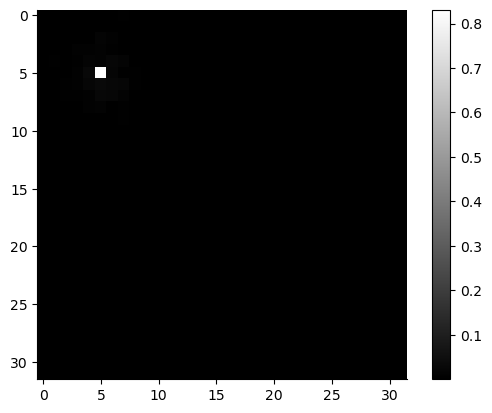

In [69]:
plt.imshow(jacobian.detach().cpu().abs().mean(0), cmap="gray")
plt.colorbar()
plt.show()

#### Function form of analysis

In [112]:
# Refactored functions for visualizing gradient maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch

def compute_gradient_map(model, x_shape, sigma_val, output_coords, device, target="denoiser"):
    """
    Compute gradient map for a specific sigma value and output coordinates.
    
    Args:
        model: The denoiser model
        x_shape: Shape of the input tensor (e.g., (3, 32, 32))
        sigma_val: Sigma value for the denoiser
        output_coords: Tuple of (channel, y, x) coordinates for the output pixel
        device: Device to run computation on
    
    Returns:
        Gradient map tensor
    """
    # Set up the output map (focusing on the specified pixel)
    output_map = torch.zeros(x_shape).to(device)
    if output_coords is None:
        # Default to center pixel if not specified
        c, h, w = x_shape
        output_map[:, h//2, w//2] = 1
    else:
        c, y, x = output_coords
        if c is None:  # If channel is None, set all channels
            output_map[:, y, x] = 1
        else:
            output_map[c, y, x] = 1
    
    # Set up the probe point
    x_probe = sigma_val * torch.randn(x_shape).to(device)
    x_probe.requires_grad_(True)
    
    # Compute the denoiser output
    t_sigma = sigma_val * torch.ones(1, device=device)
    denoised = model(x_probe.view(1, *x_shape), t_sigma)
    if target == "denoiser":
        scalar = (output_map * denoised).sum()
    elif target == "score":
        score = (denoised - x_probe.view(1, *x_shape)) / t_sigma[:, None]
        scalar = (output_map * score[0]).sum()
    else:
        raise ValueError(f"Invalid target: {target}")
    
    # Compute scalar output and get gradient
    scalar.backward()
    # Return the gradient
    return x_probe.grad.detach().cpu()

def visualize_gradient_maps(model, x_shape, sigma_values, output_coords=None, target="denoiser",
                           device='cuda', reduction='abs_mean', figsize=(14, 14)):
    """
    Visualize gradient maps for different sigma values.
    
    Args:
        model: The denoiser model
        x_shape: Shape of the input tensor (e.g., (3, 32, 32))
        sigma_values: List of sigma values to test
        output_coords: Tuple of (channel, y, x) coordinates for the output pixel
                      If None, defaults to center pixel
        device: Device to run computation on
        reduction: How to reduce channel dimension ('abs_mean', 'mean', 'max', or None)
        figsize: Figure size for the plot
    
    Returns:
        List of computed gradient maps
    """
    gradient_maps = []
    
    # Compute gradient maps for each sigma
    for sigma_val in sigma_values:
        print(f"Computing gradient map for sigma = {sigma_val}")
        gradient_map = compute_gradient_map(model, x_shape, sigma_val, output_coords, device, target=target)
        
        # Apply reduction if specified
        if reduction == 'abs_mean':
            gradient_map = gradient_map.abs().mean(0)
        elif reduction == 'mean':
            gradient_map = gradient_map.mean(0)
        elif reduction == 'max':
            gradient_map = gradient_map.abs().max(0)[0]
        # If None, keep all channels
        
        gradient_maps.append(gradient_map)
        # Clear gradients for next iteration
        torch.cuda.empty_cache()
    
    # Create a montage of the gradient maps
    rows = int(len(sigma_values)**0.5)
    cols = (len(sigma_values) + rows - 1) // rows  # Ceiling division
    
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(rows, cols),
                    axes_pad=0.3,
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.1)
    
    # Add each gradient map to the grid
    for i, (gradient_map, sigma_val) in enumerate(zip(gradient_maps, sigma_values)):
        if i < len(grid):  # Ensure we don't go out of bounds
            ax = grid[i]
            
            # Handle multi-channel gradient maps
            if len(gradient_map.shape) == 3 and reduction is None:
                # Just show first channel if no reduction
                im = ax.imshow(gradient_map[0], cmap="viridis")
            else:
                im = ax.imshow(gradient_map, cmap="viridis")
                
            ax.set_title(f"σ = {sigma_val}")
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add colorbar
    grid.cbar_axes[0].colorbar(im)
    
    # Add title with output coordinates
    if output_coords:
        c, y, x = output_coords
        channel_str = f"channel {c}" if c is not None else "all channels"
        plt.suptitle(f"Gradient Maps of {target} for Different Sigma Values (Output at {channel_str}, y={y}, x={x})")
    else:
        plt.suptitle(f"Gradient Maps of {target} for Different Sigma Values (Output at center pixel)")
    
    plt.tight_layout()
    plt.show()
    
    return gradient_maps


#### Gradient Map of CNN Unet denoisers

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


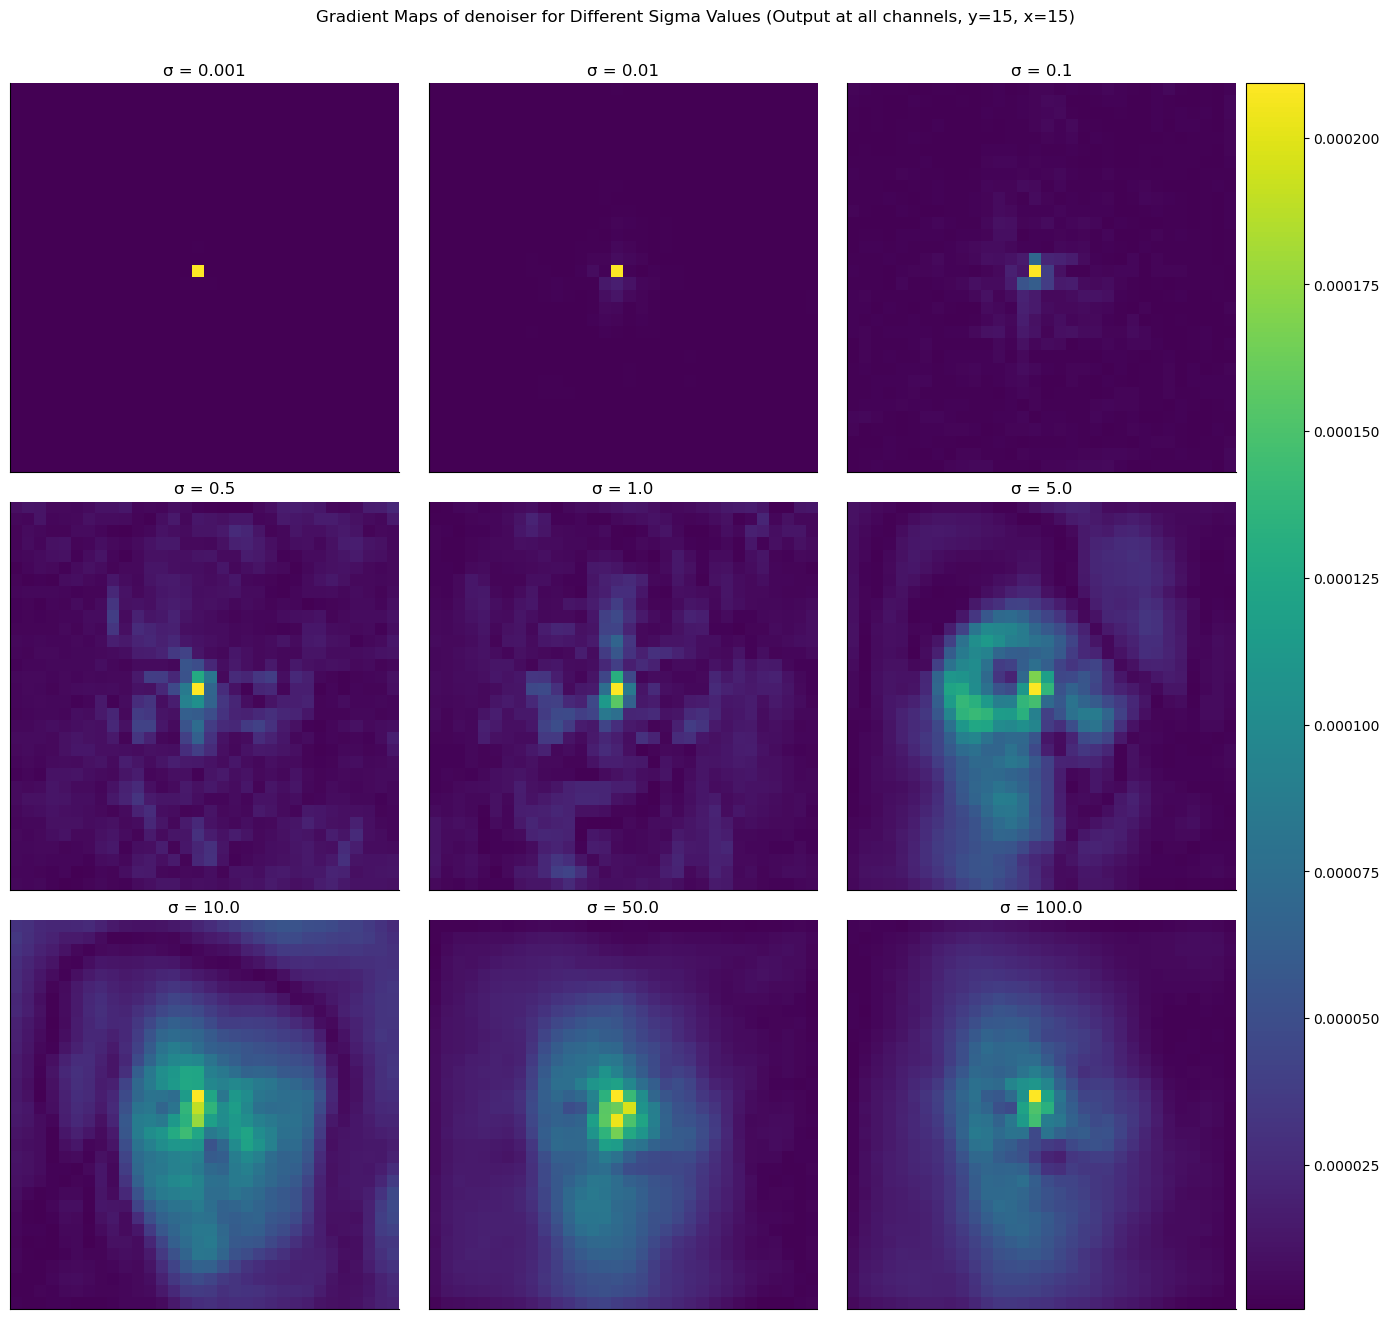

In [113]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 15, 15), target="denoiser");

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


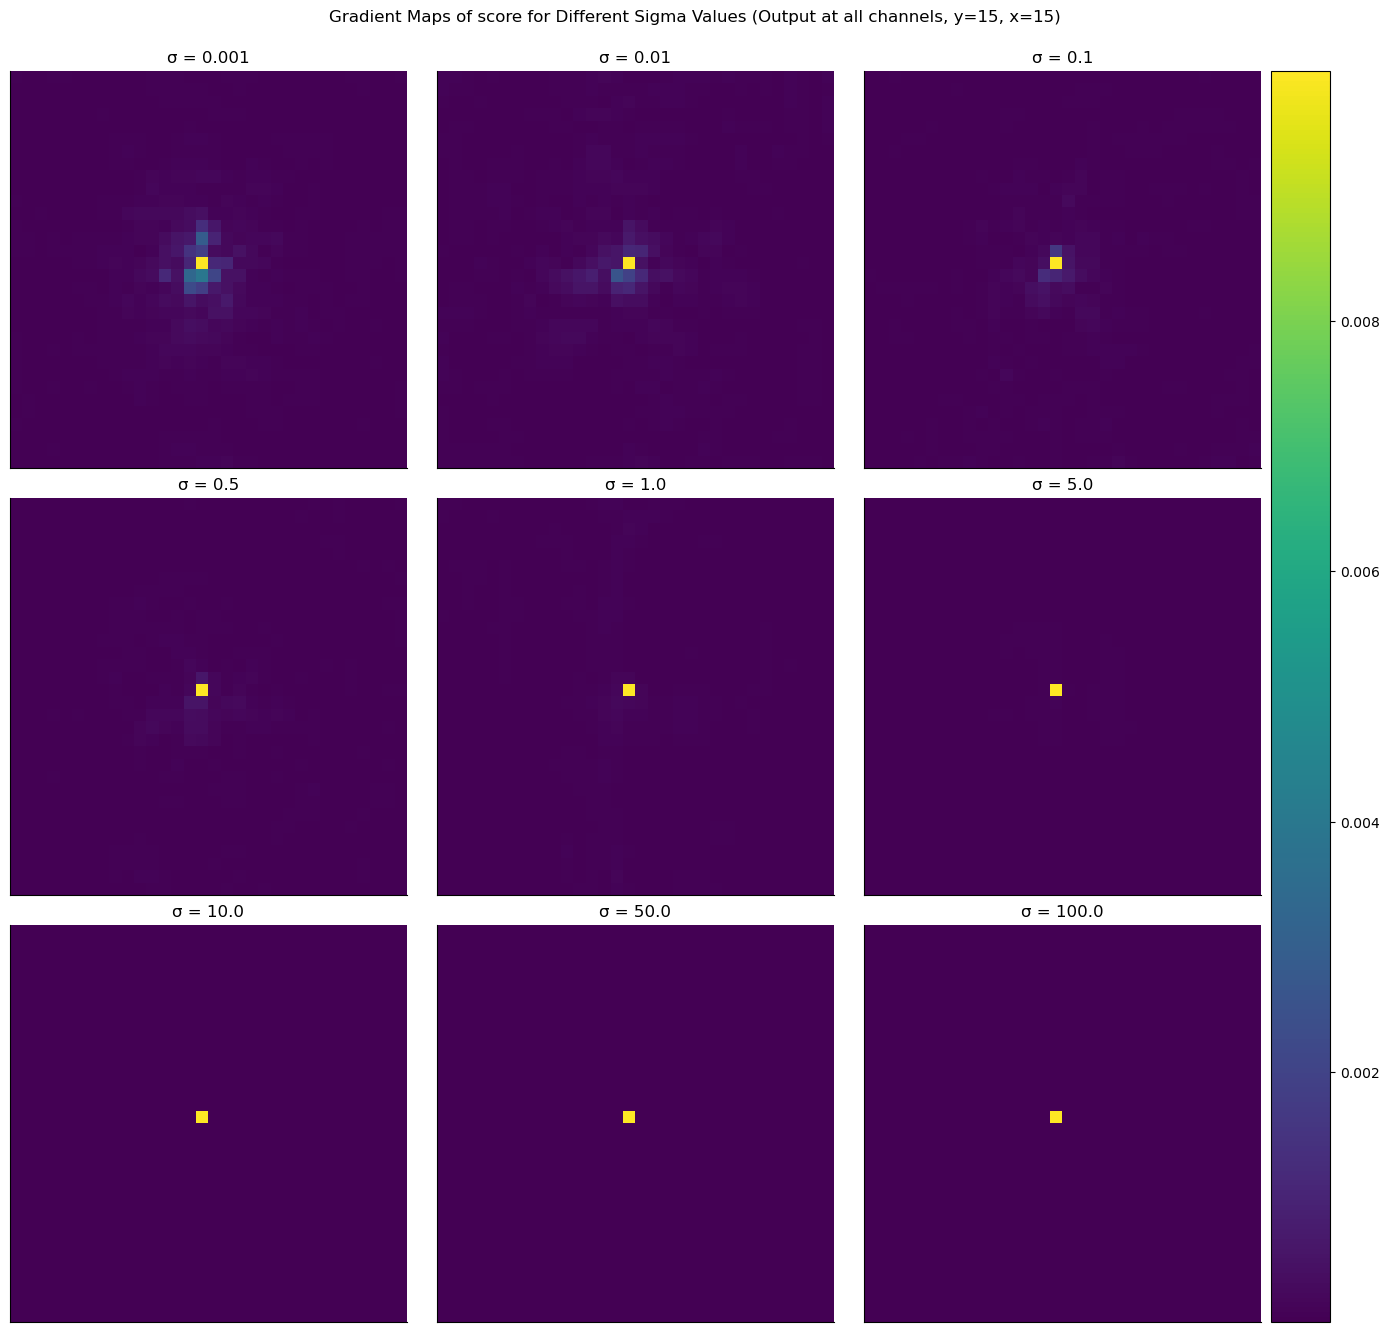

In [114]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 15, 15), target="score");

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


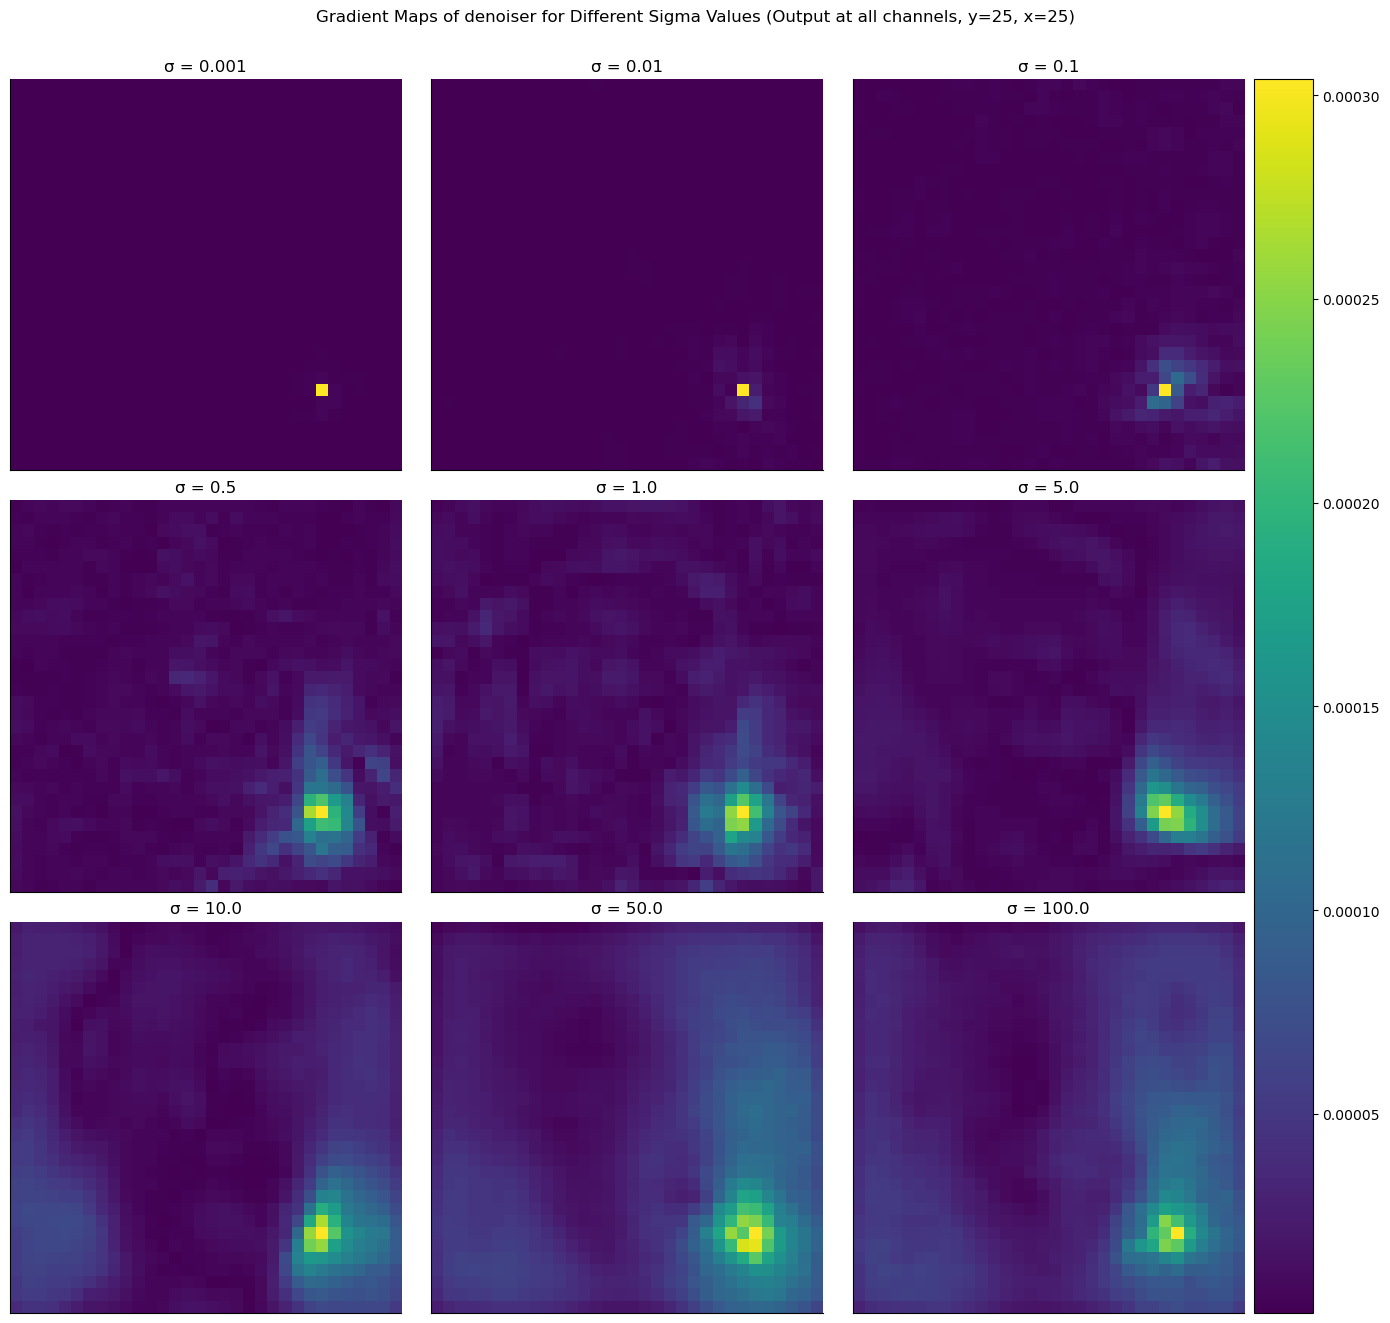

In [115]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 25, 25));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


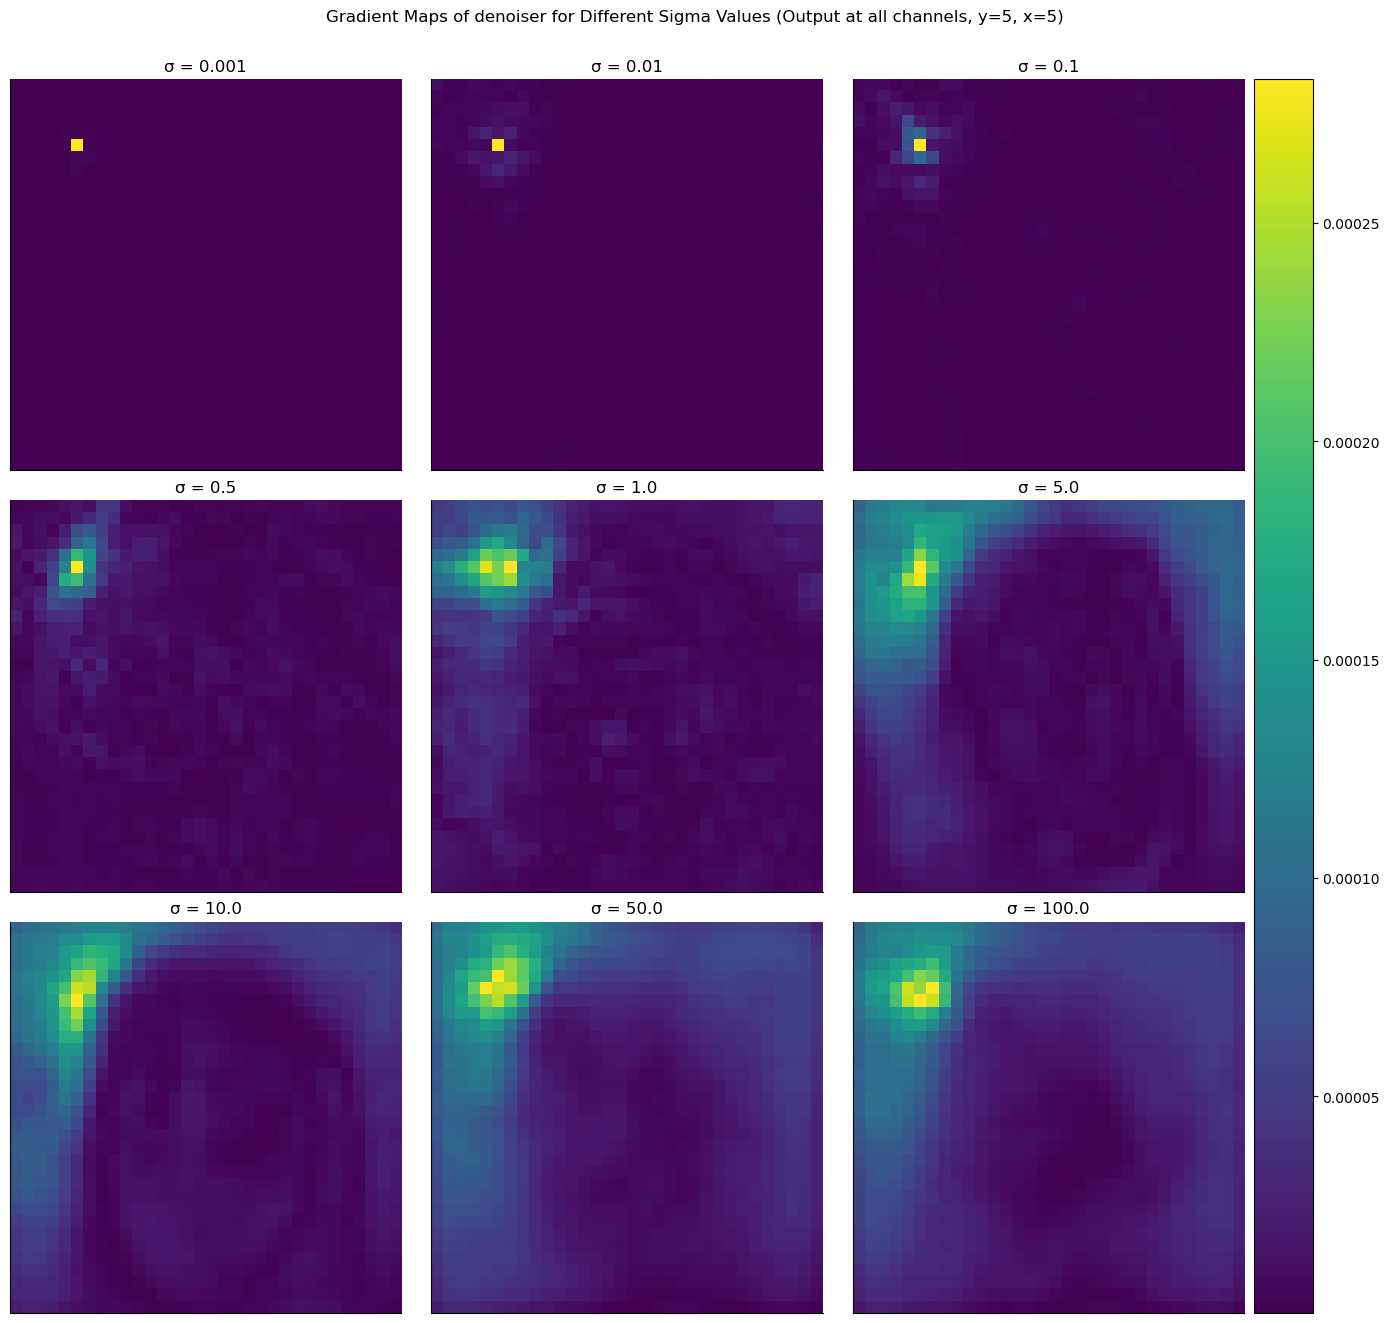

In [116]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 5, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


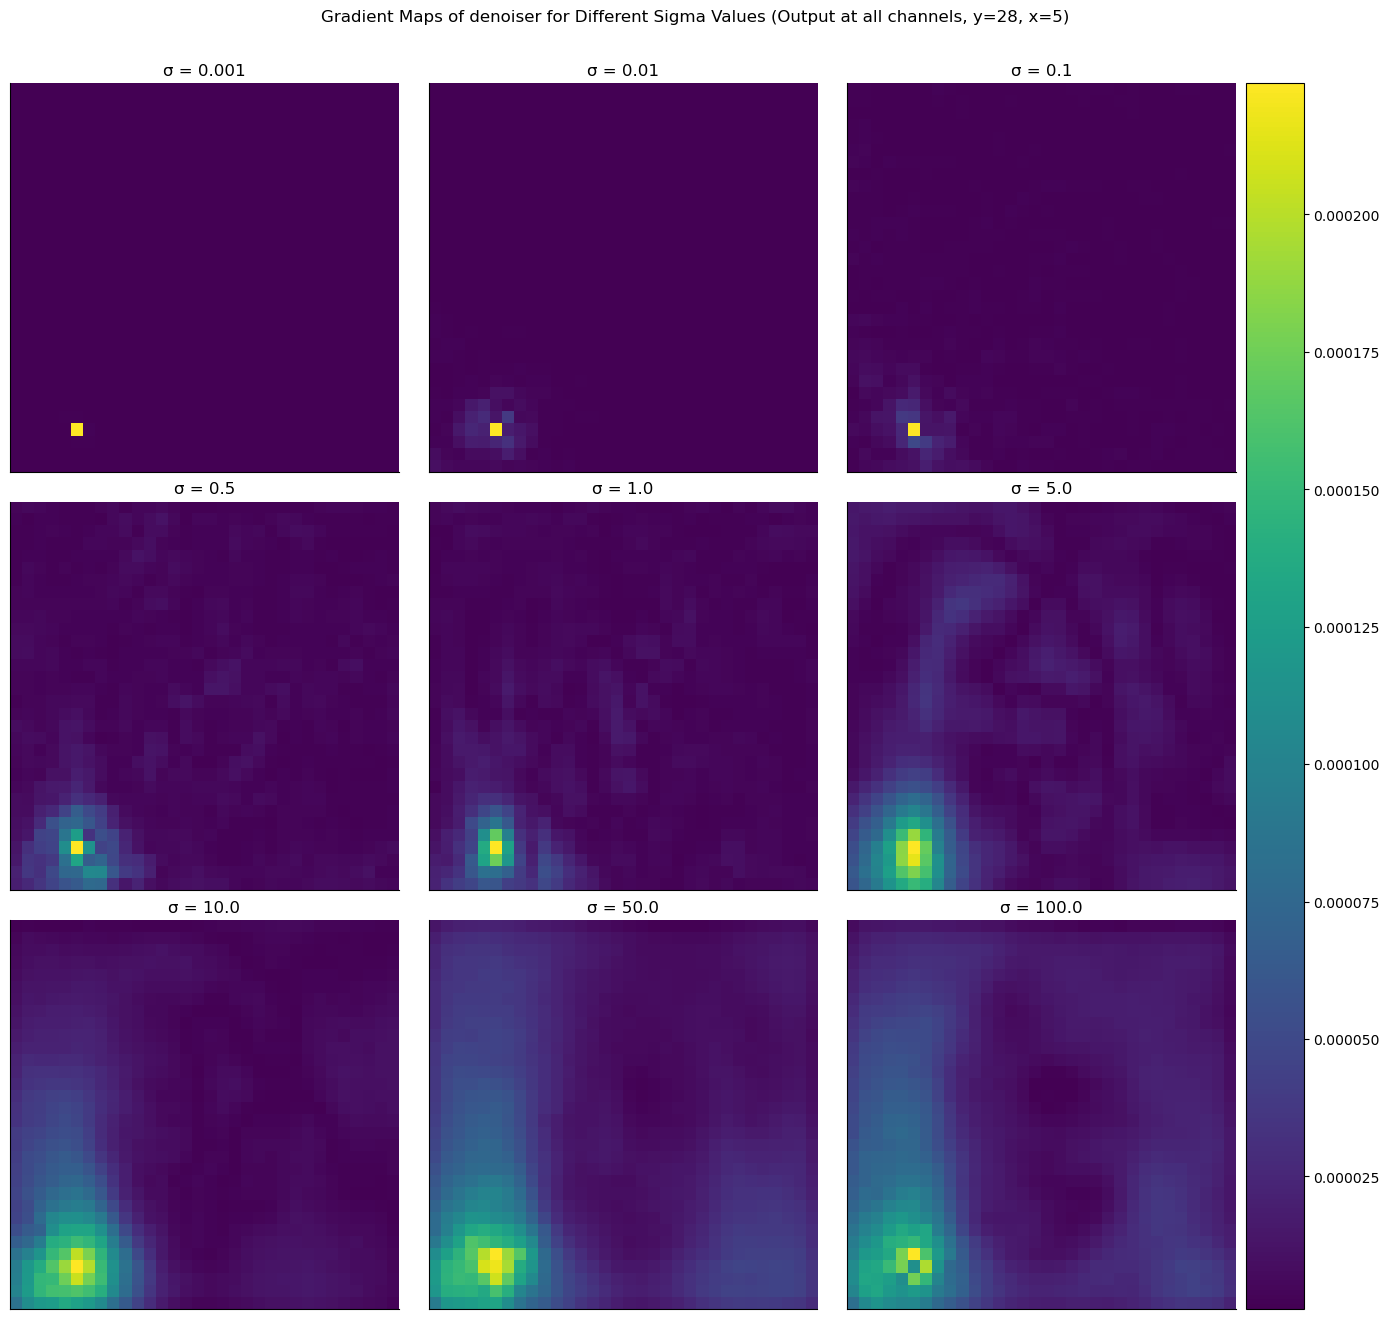

In [117]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 28, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


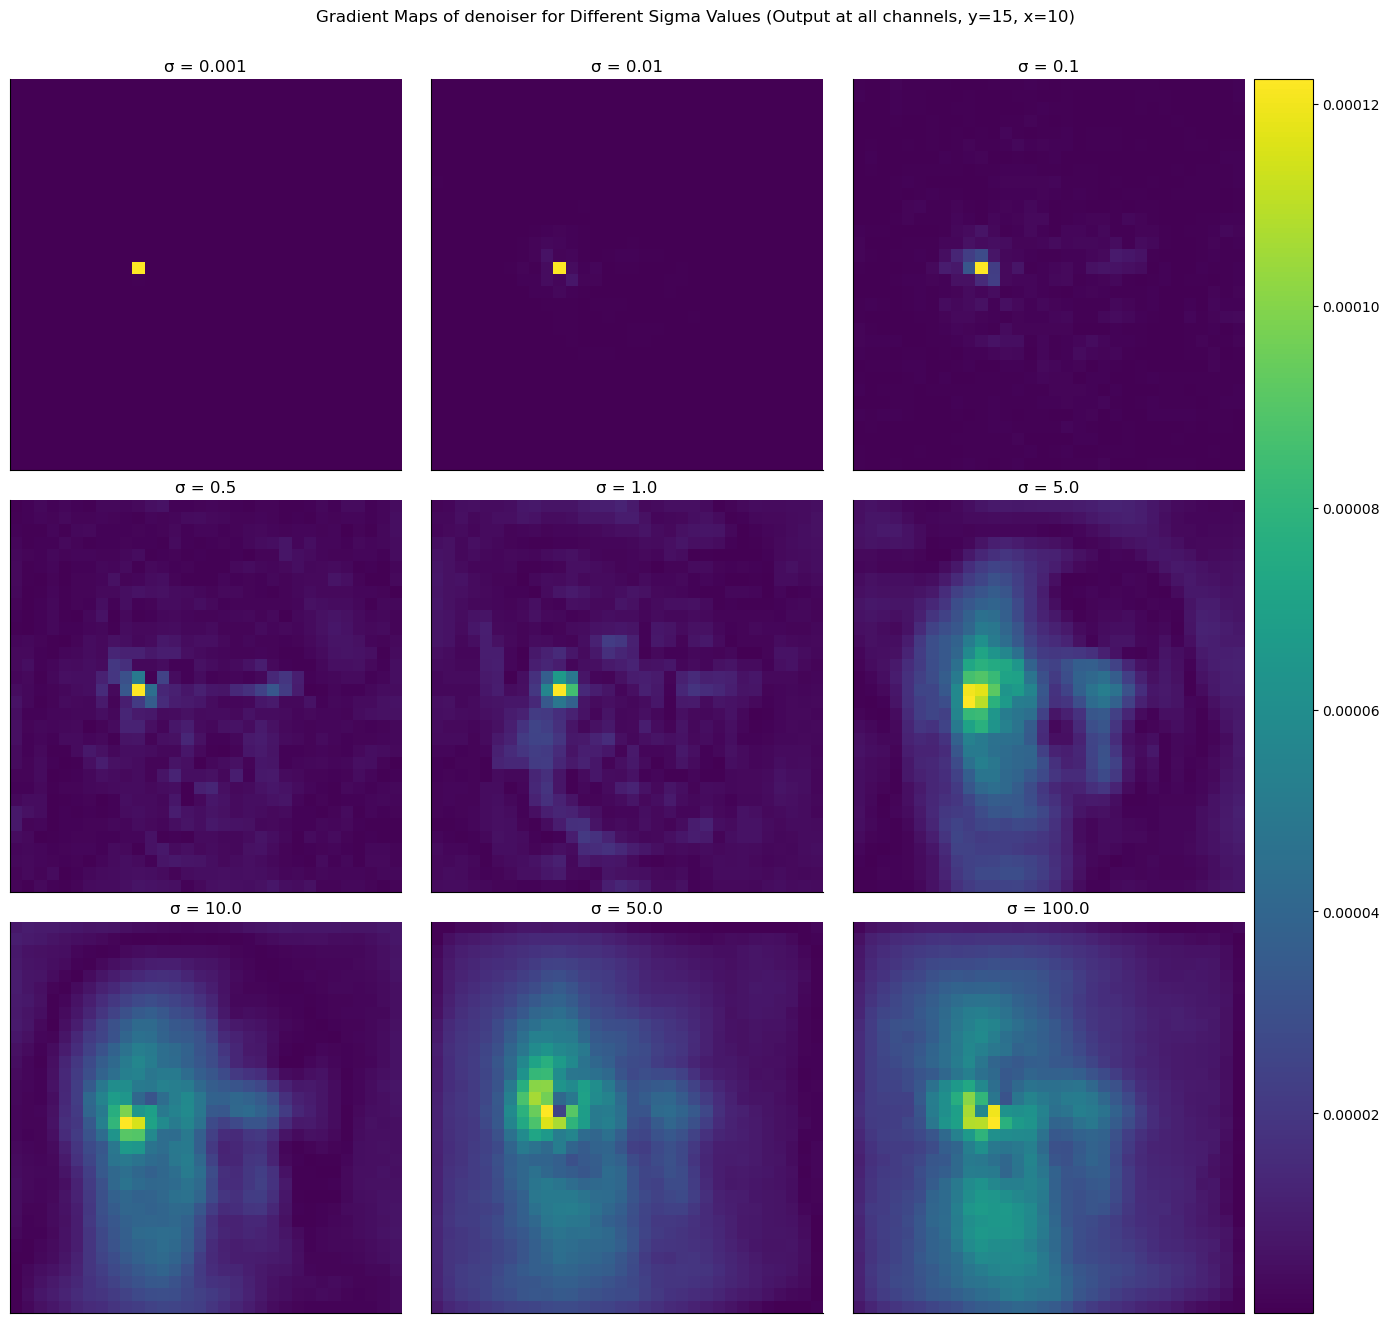

In [118]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 15, 10));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


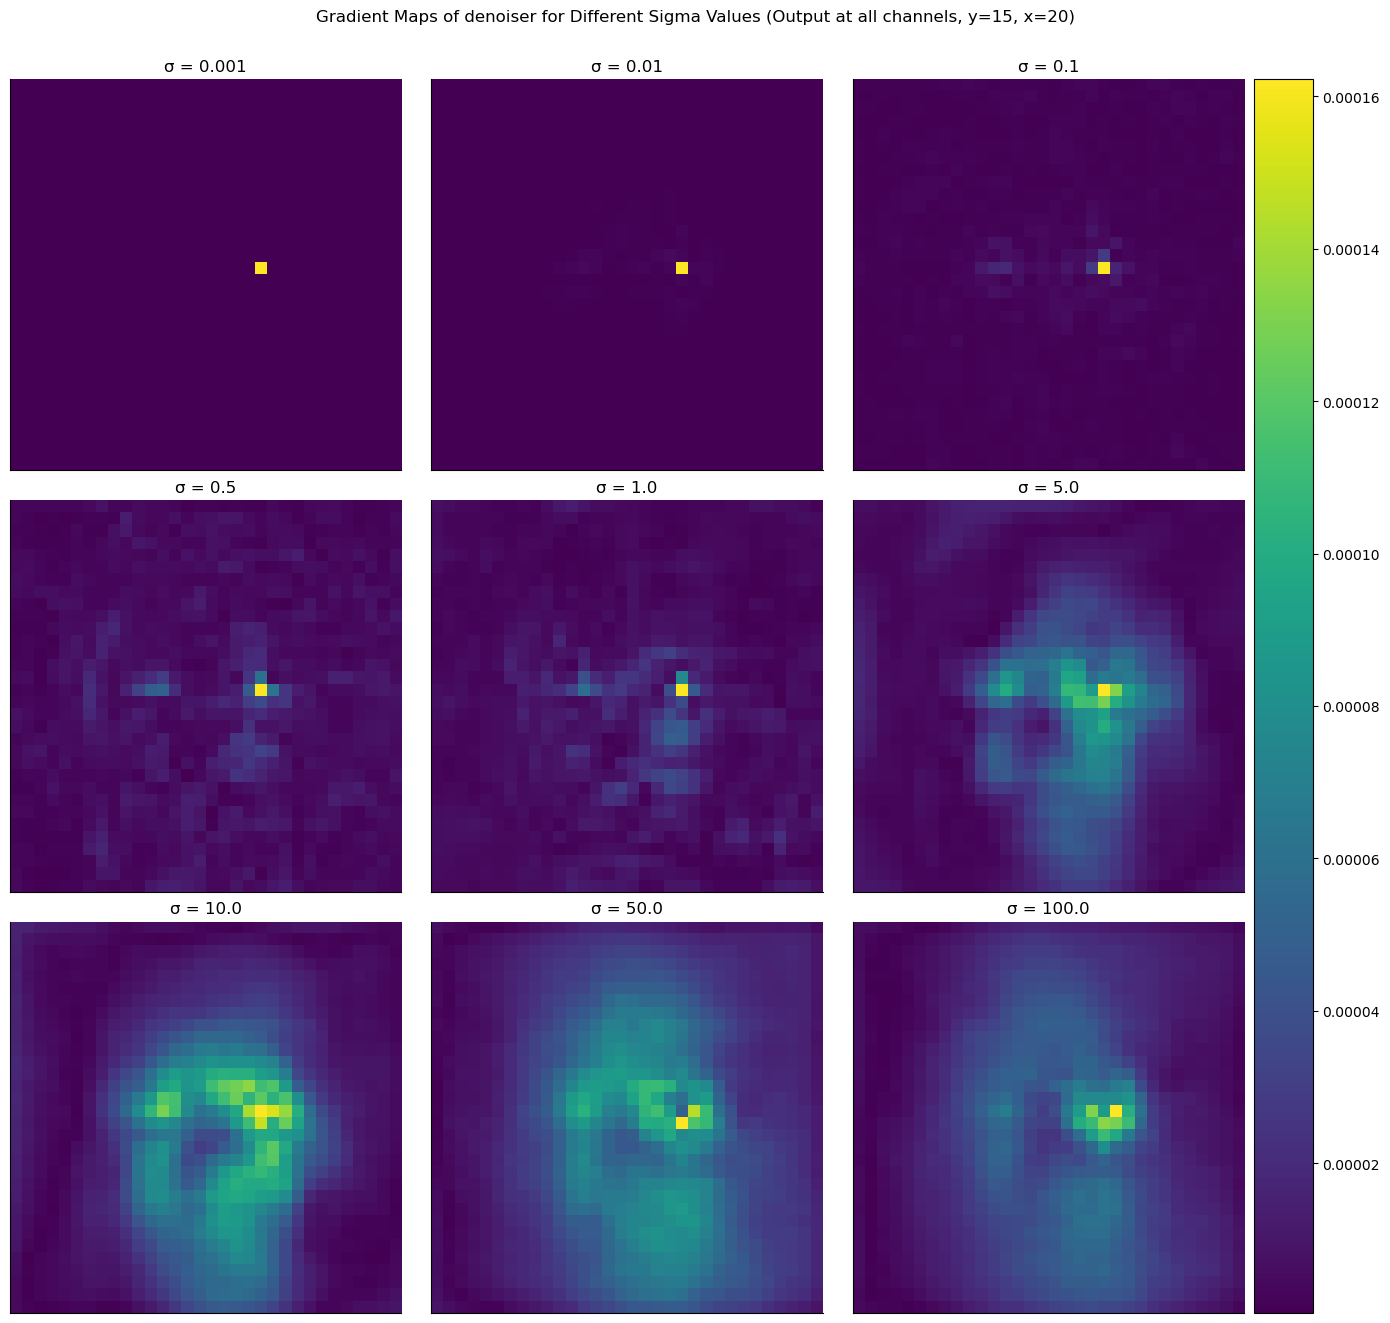

In [119]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(CNN_precd, imgshape, sigma_values, output_coords=(None, 15, 20));

#### Scratch

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/500733283.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


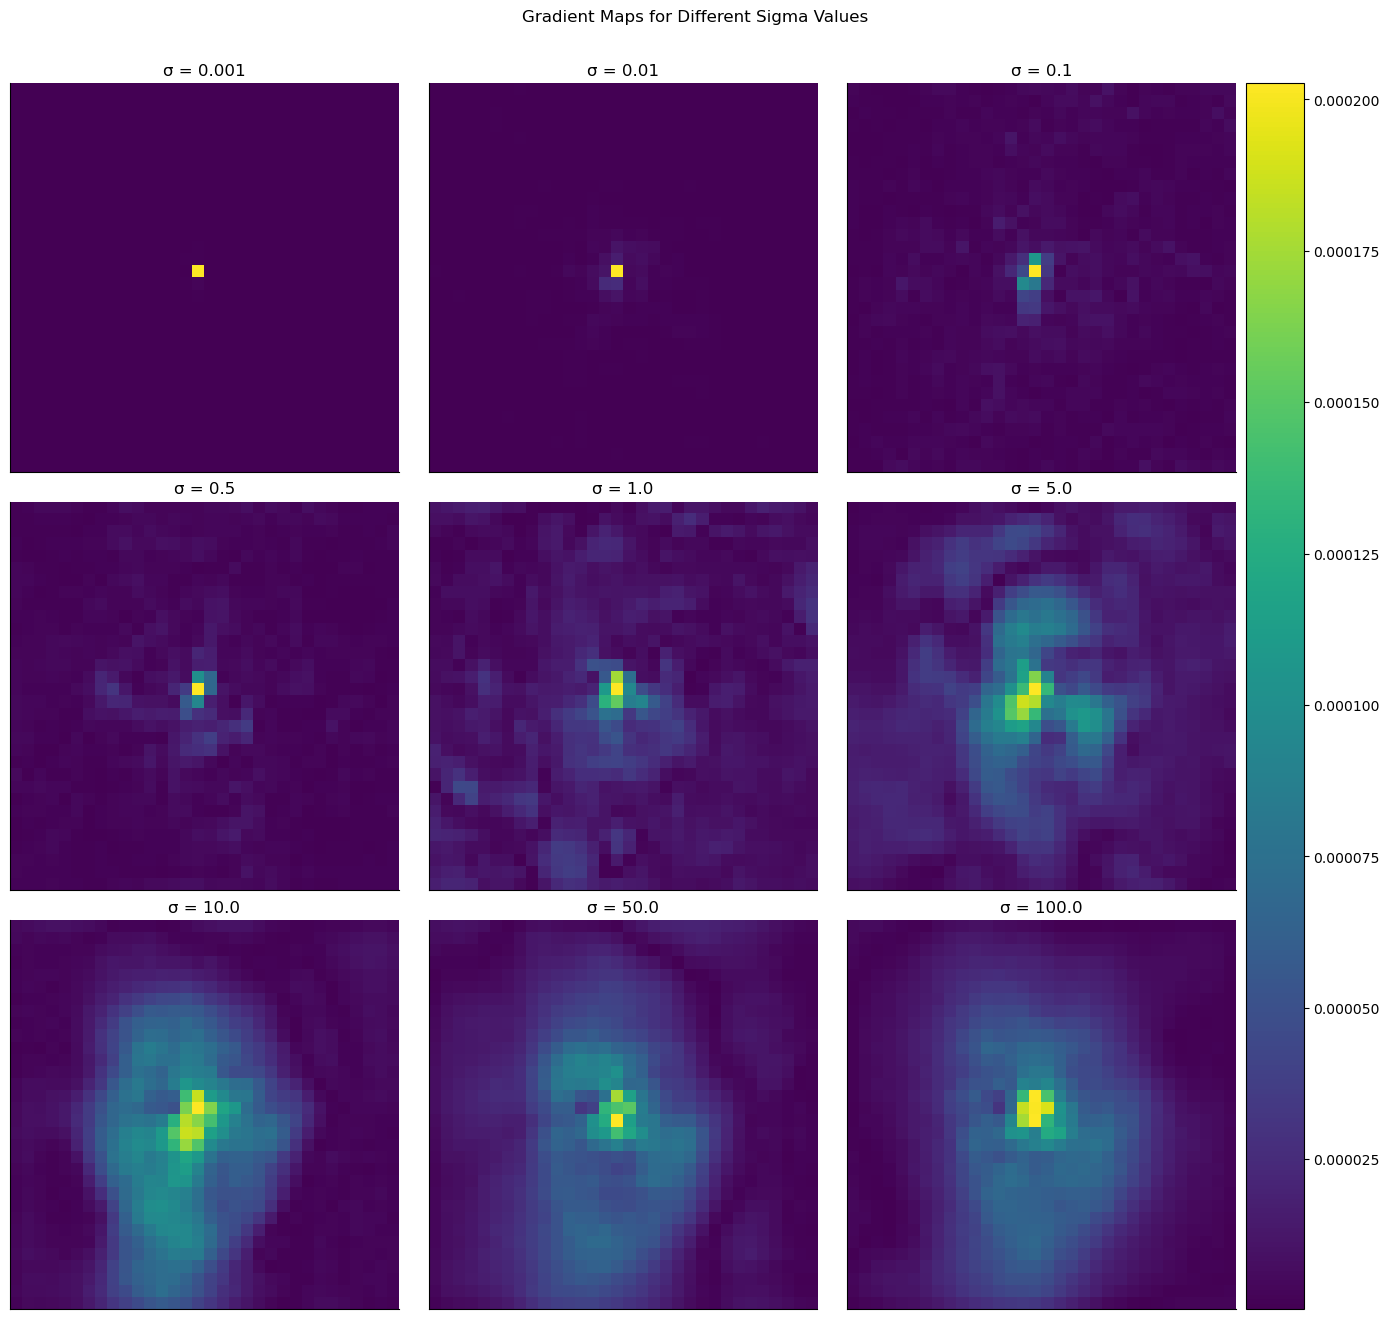

In [ ]:
# Compute gradient maps for different sigma values and create a montage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Define a range of sigma values to test
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
gradient_maps = []

# Set up the output map (focusing on the same pixel)
output_map = torch.zeros(*imgshape).to(device)
output_map[:, 15, 15] = 1
# Function to compute gradient map for a given sigma
def compute_denoiser_gradient_map(sigma_val):
    # Set up the probe point
    x_probe = sigma_val * torch.randn(*imgshape).to(device)
    x_probe.requires_grad_(True)
    # Compute the denoiser output
    t_sigma = sigma_val * torch.ones(1, device=device)
    denoised = CNN_precd(x_probe.view(1, *imgshape), t_sigma)
    # Compute scalar output and get gradient
    scalar = (output_map * denoised[0]).sum()
    scalar.backward()
    # Return the gradient
    return x_probe.grad.detach().cpu().abs().mean(0)

# Compute gradient maps for each sigma
for sigma_val in sigma_values:
    print(f"Computing gradient map for sigma = {sigma_val}")
    gradient_map = compute_denoiser_gradient_map(sigma_val)
    gradient_maps.append(gradient_map)
    # Clear gradients for next iteration
    torch.cuda.empty_cache()

# Create a montage of the gradient maps
fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, len(sigma_values)//3),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.1)

# Add each gradient map to the grid
# No need to flatten grid - ImageGrid is already iterable through its axes
for i, gradient_map, sigma_val in zip(range(len(gradient_maps)), gradient_maps, sigma_values):
    ax = grid[i]  # Access grid elements by index
    im = ax.imshow(gradient_map, cmap="viridis")
    ax.set_title(f"σ = {sigma_val}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbar
grid.cbar_axes[0].colorbar(im)
plt.suptitle("Gradient Maps of Denoiser D(x, sigma) for Different Sigma Values")
plt.tight_layout()
plt.show()


Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/4005274271.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


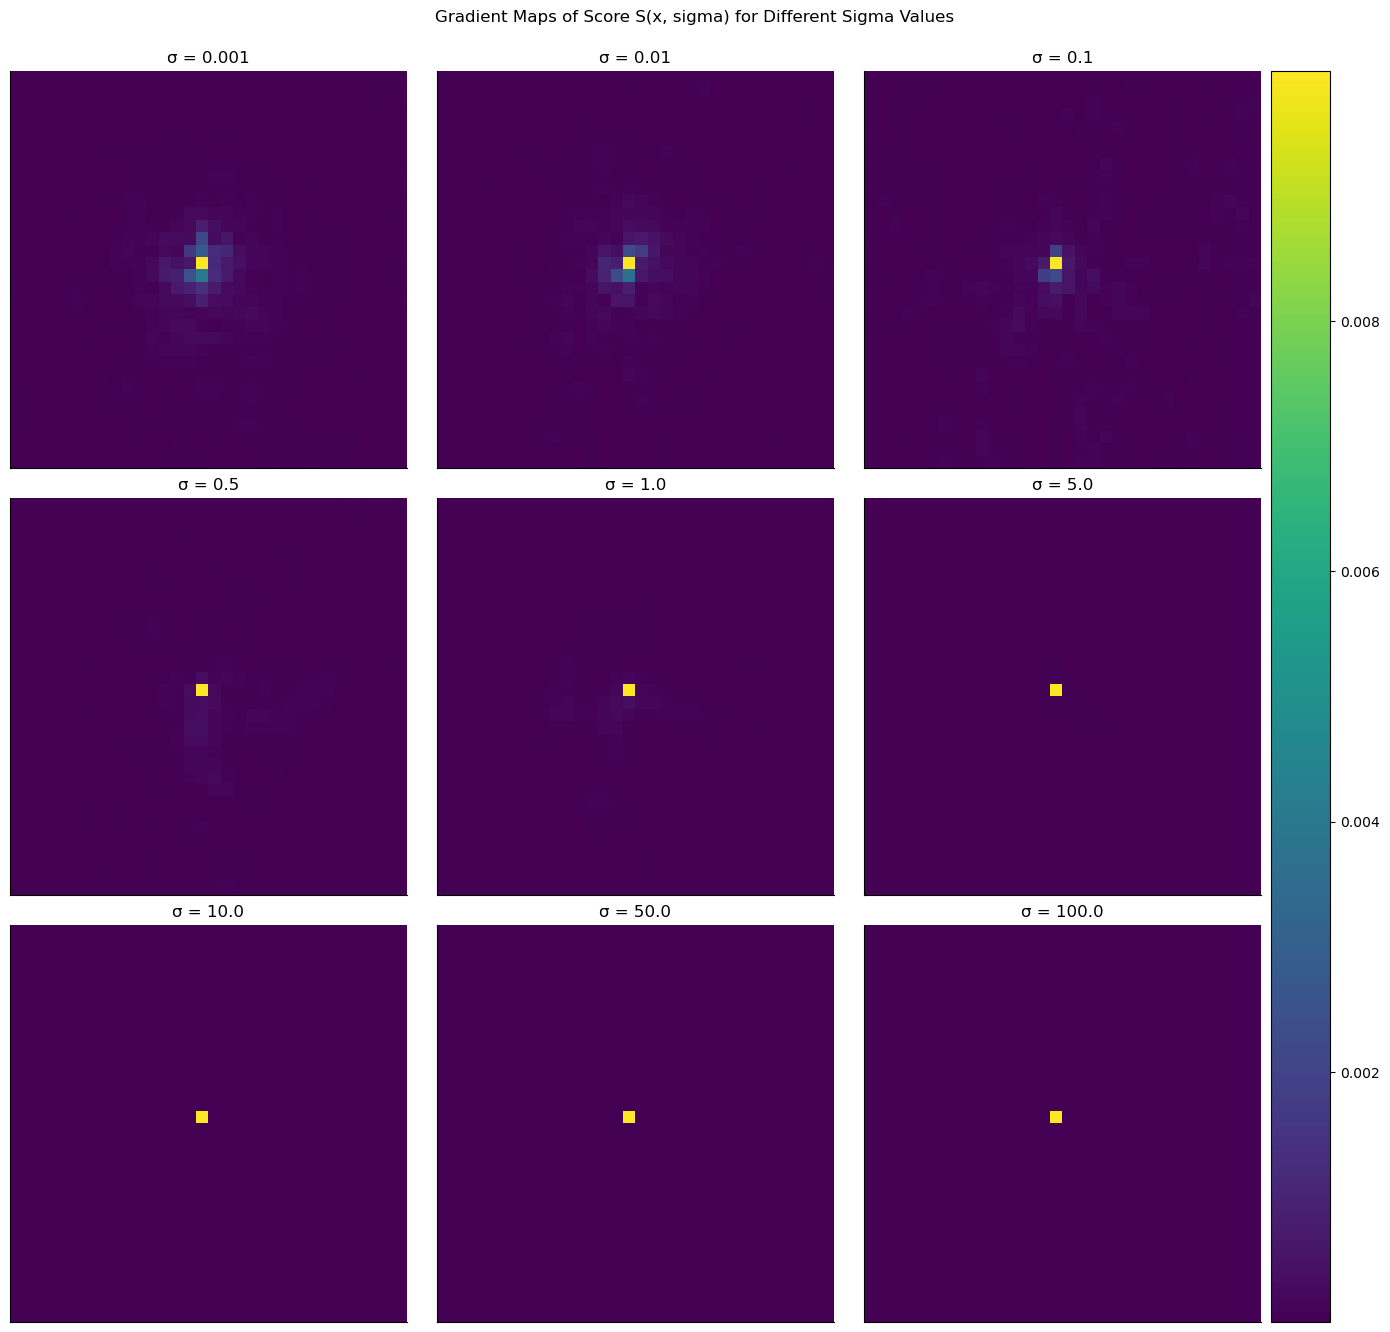

In [58]:
# Compute gradient maps for different sigma values and create a montage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Define a range of sigma values to test
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
gradient_maps = []

# Set up the output map (focusing on the same pixel)
output_map = torch.zeros(*imgshape).to(device)
output_map[:, 15, 15] = 1
# Function to compute gradient map for a given sigma
def compute_score_gradient_map(sigma_val):
    # Set up the probe point
    x_probe = sigma_val * torch.randn(*imgshape).to(device)
    x_probe.requires_grad_(True)
    # Compute the denoiser output
    t_sigma = sigma_val * torch.ones(1, device=device)
    denoised = CNN_precd(x_probe[None,], t_sigma)
    score = (denoised - x_probe[None,]) / t_sigma[:, None]
    # Compute scalar output and get gradient
    scalar = (output_map * score[0]).sum()
    scalar.backward()
    # Return the gradient
    return x_probe.grad.detach().cpu().abs().mean(0)

# Compute gradient maps for each sigma
for sigma_val in sigma_values:
    print(f"Computing gradient map for sigma = {sigma_val}")
    gradient_map = compute_score_gradient_map(sigma_val)
    gradient_maps.append(gradient_map)
    # Clear gradients for next iteration
    torch.cuda.empty_cache()

# Create a montage of the gradient maps
fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, len(sigma_values)//3),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.1)

# Add each gradient map to the grid
# No need to flatten grid - ImageGrid is already iterable through its axes
for i, gradient_map, sigma_val in zip(range(len(gradient_maps)), gradient_maps, sigma_values):
    ax = grid[i]  # Access grid elements by index
    im = ax.imshow(gradient_map, cmap="viridis")
    ax.set_title(f"σ = {sigma_val}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbar
grid.cbar_axes[0].colorbar(im)
plt.suptitle("Gradient Maps of Score S(x, sigma) for Different Sigma Values")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1050056/877178136.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


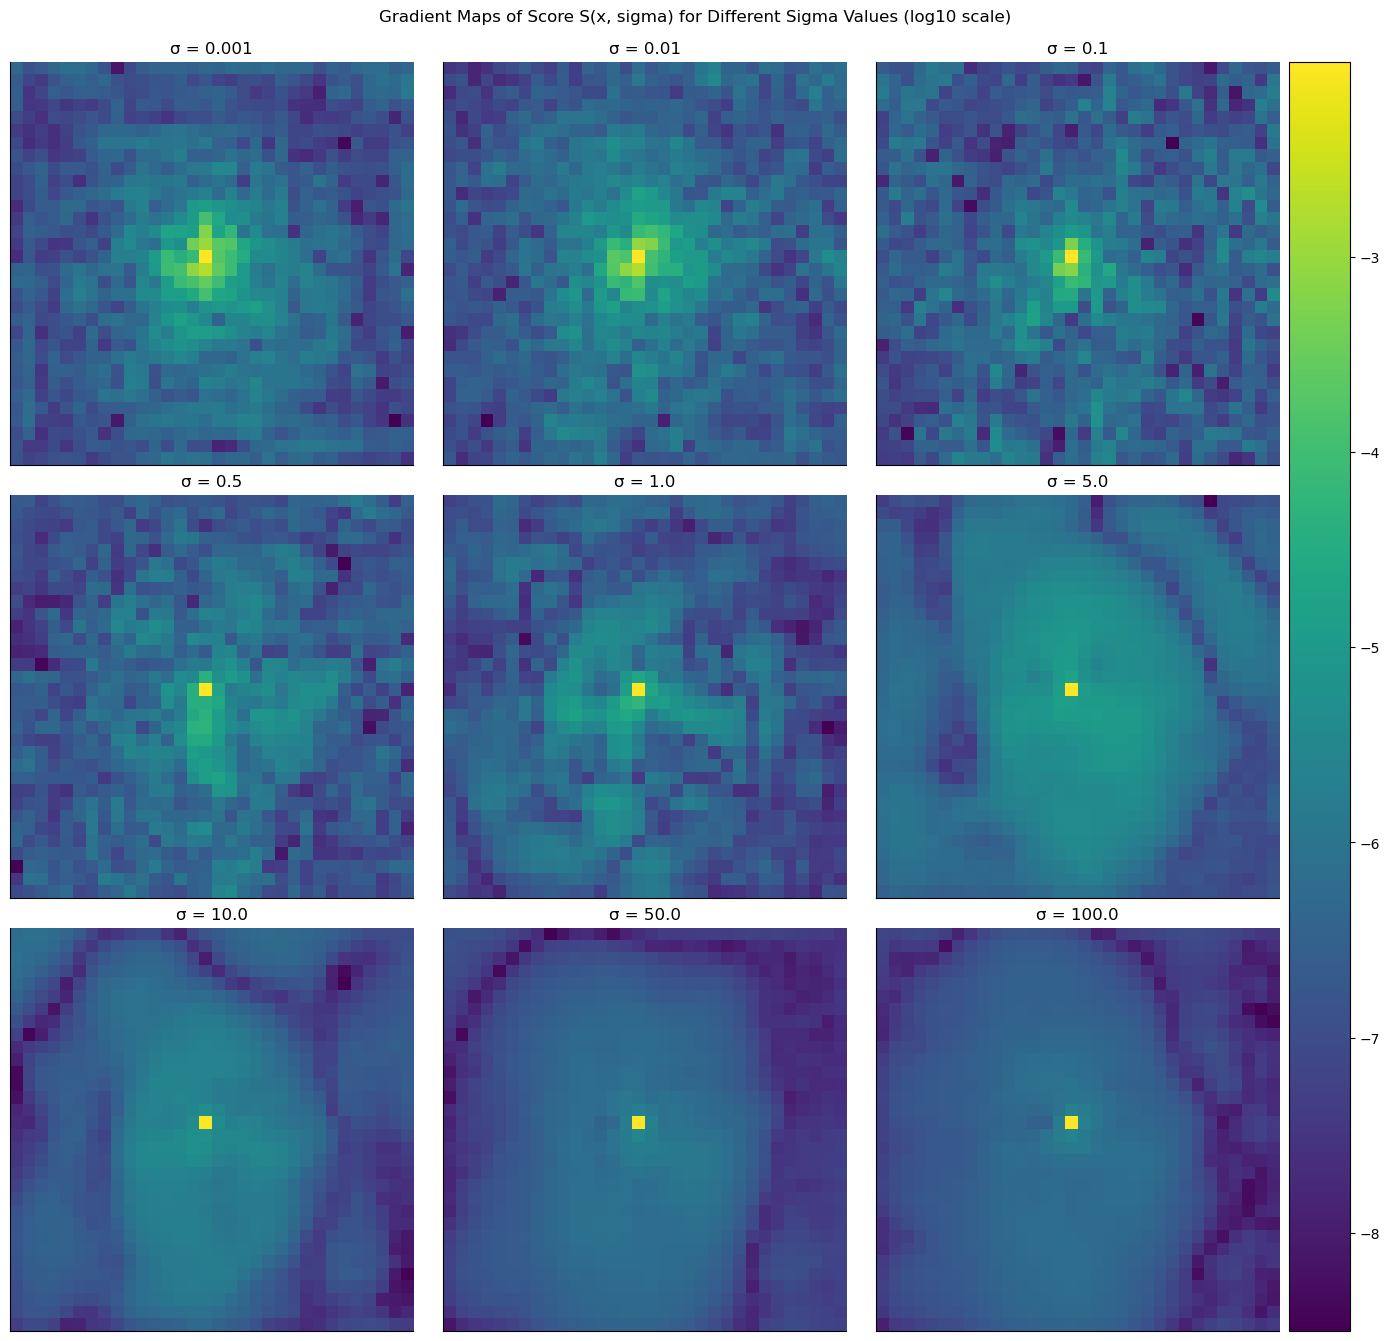

In [59]:
# Create a montage of the gradient maps
fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, len(sigma_values)//3),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.1)

# Add each gradient map to the grid
# No need to flatten grid - ImageGrid is already iterable through its axes
for i, gradient_map, sigma_val in zip(range(len(gradient_maps)), gradient_maps, sigma_values):
    ax = grid[i]  # Access grid elements by index
    im = ax.imshow(gradient_map.log10(), cmap="viridis")
    ax.set_title(f"σ = {sigma_val}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbar
grid.cbar_axes[0].colorbar(im)
plt.suptitle("Gradient Maps of Score S(x, sigma) for Different Sigma Values (log10 scale)")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.func import vmap, jacrev

# Use functorch's jacrev to get the Jacobian of compute_score
jacobian_fn = jacrev(compute_score)
# # Create a regular grid of points
# x = torch.linspace(-5, 5, 100)
# y = torch.linspace(-5, 5, 100)
# X, Y = torch.meshgrid(x, y, indexing='ij')
# x_probe = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
x_probe = torch.randn(1, *imgshape).to(device)
# Use vmap to vectorize the computation over all points in x_probe
jacobians = vmap(jacobian_fn)(x_probe).detach().cpu()  
# jacobians_maps = jacobians.reshape(100, 100, 2, 2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 

In [20]:
# compute the jacobian a function N to N
sigma = 0.5
def mapping(x):
    return CNN_precd(x, sigma * torch.ones(x.shape[0], device=x.device))

# compute the jacobian of the mapping


### Loading MLP

In [120]:
# loading config 
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
# config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
img_ndim = 3072
MLP_model = UNetBlockStyleMLP_backbone(ndim=img_ndim, nlayers=args.mlp_layers, nhidden=args.mlp_hidden_dim, time_embed_dim=args.mlp_time_embed_dim,)
MLP_precd = EDMPrecondWrapper(MLP_model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

In [121]:
# ckpt_step = 9705
ckpt_step = find_largest_ckpt_step(ckptdir)
ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
MLP_precd.load_state_dict(torch.load(ckpt_path))

Found 88 checkpoints in the directory, largest step is 49999


<All keys matched successfully>

In [122]:
MLP_precd.requires_grad_(False)
MLP_precd = MLP_precd.to(device).eval();
MLP_precd_img = lambda x, sigma: MLP_precd(x.view(x.shape[0], -1), sigma).view(-1,*imgshape) # to have the same signature as the other denoisers

#### Gradient Map of MLP denoisers

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


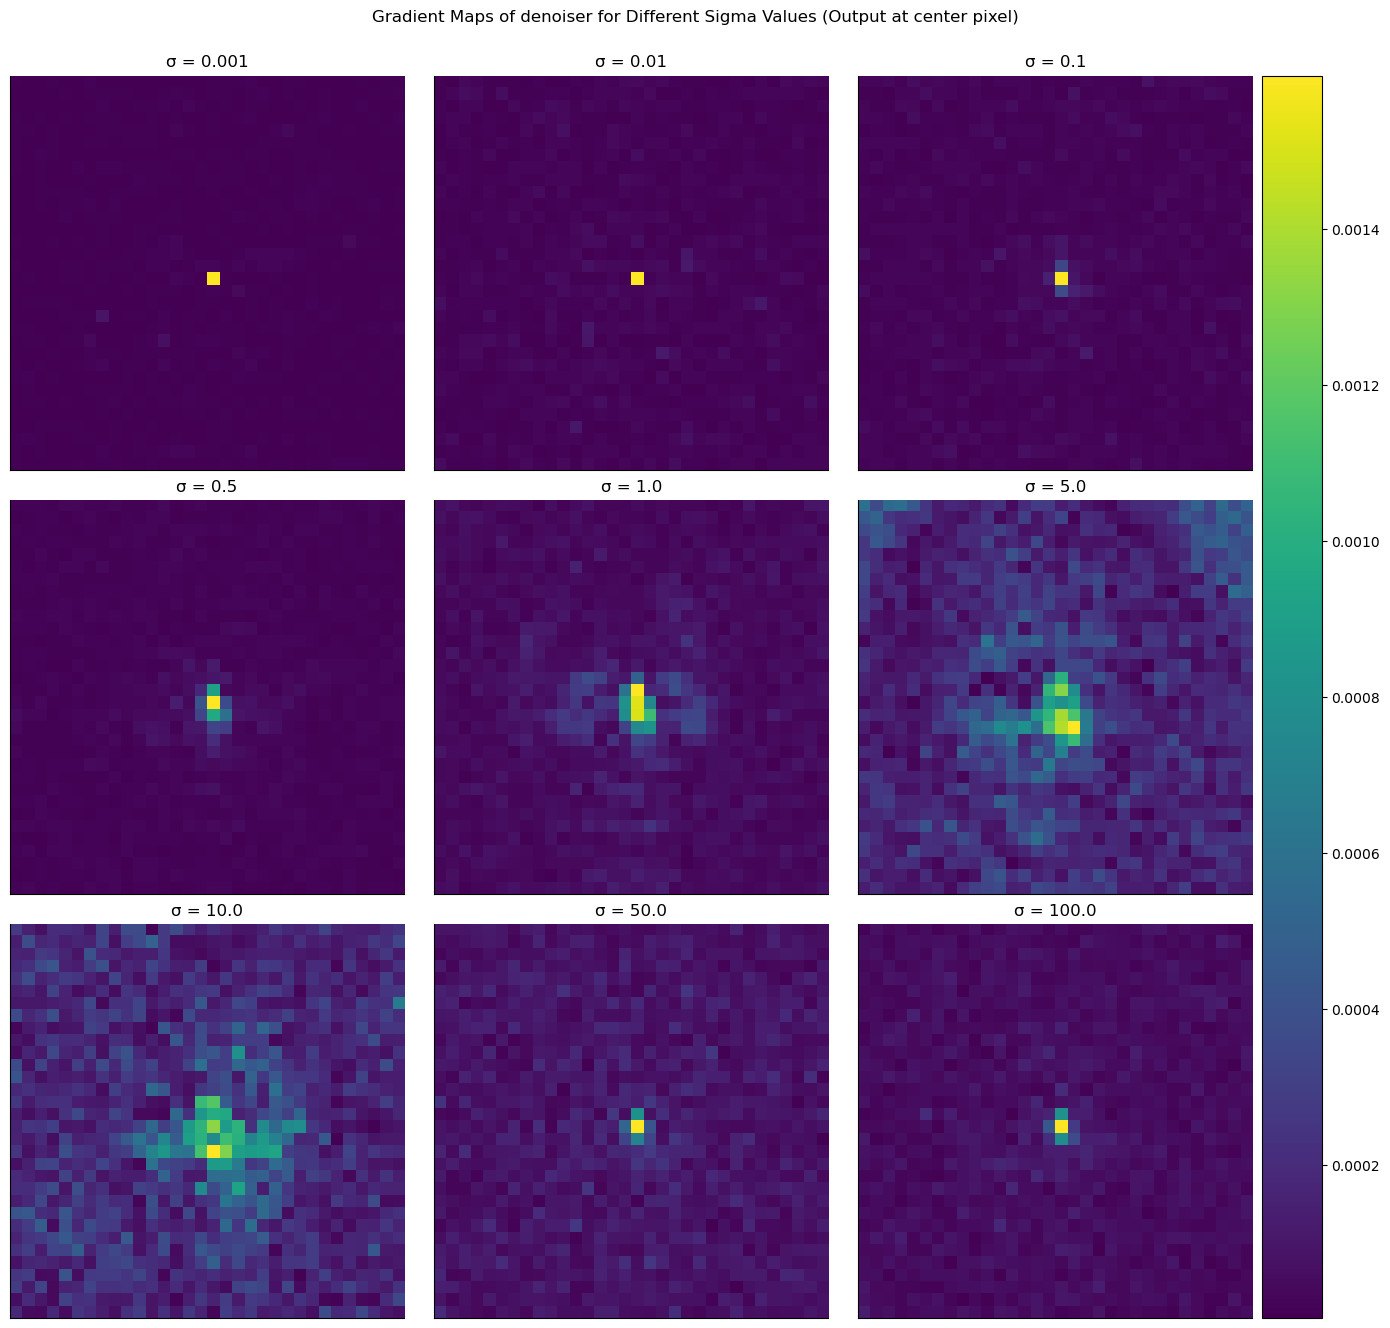

In [123]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, target="denoiser");#output_coords=(None, 28, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


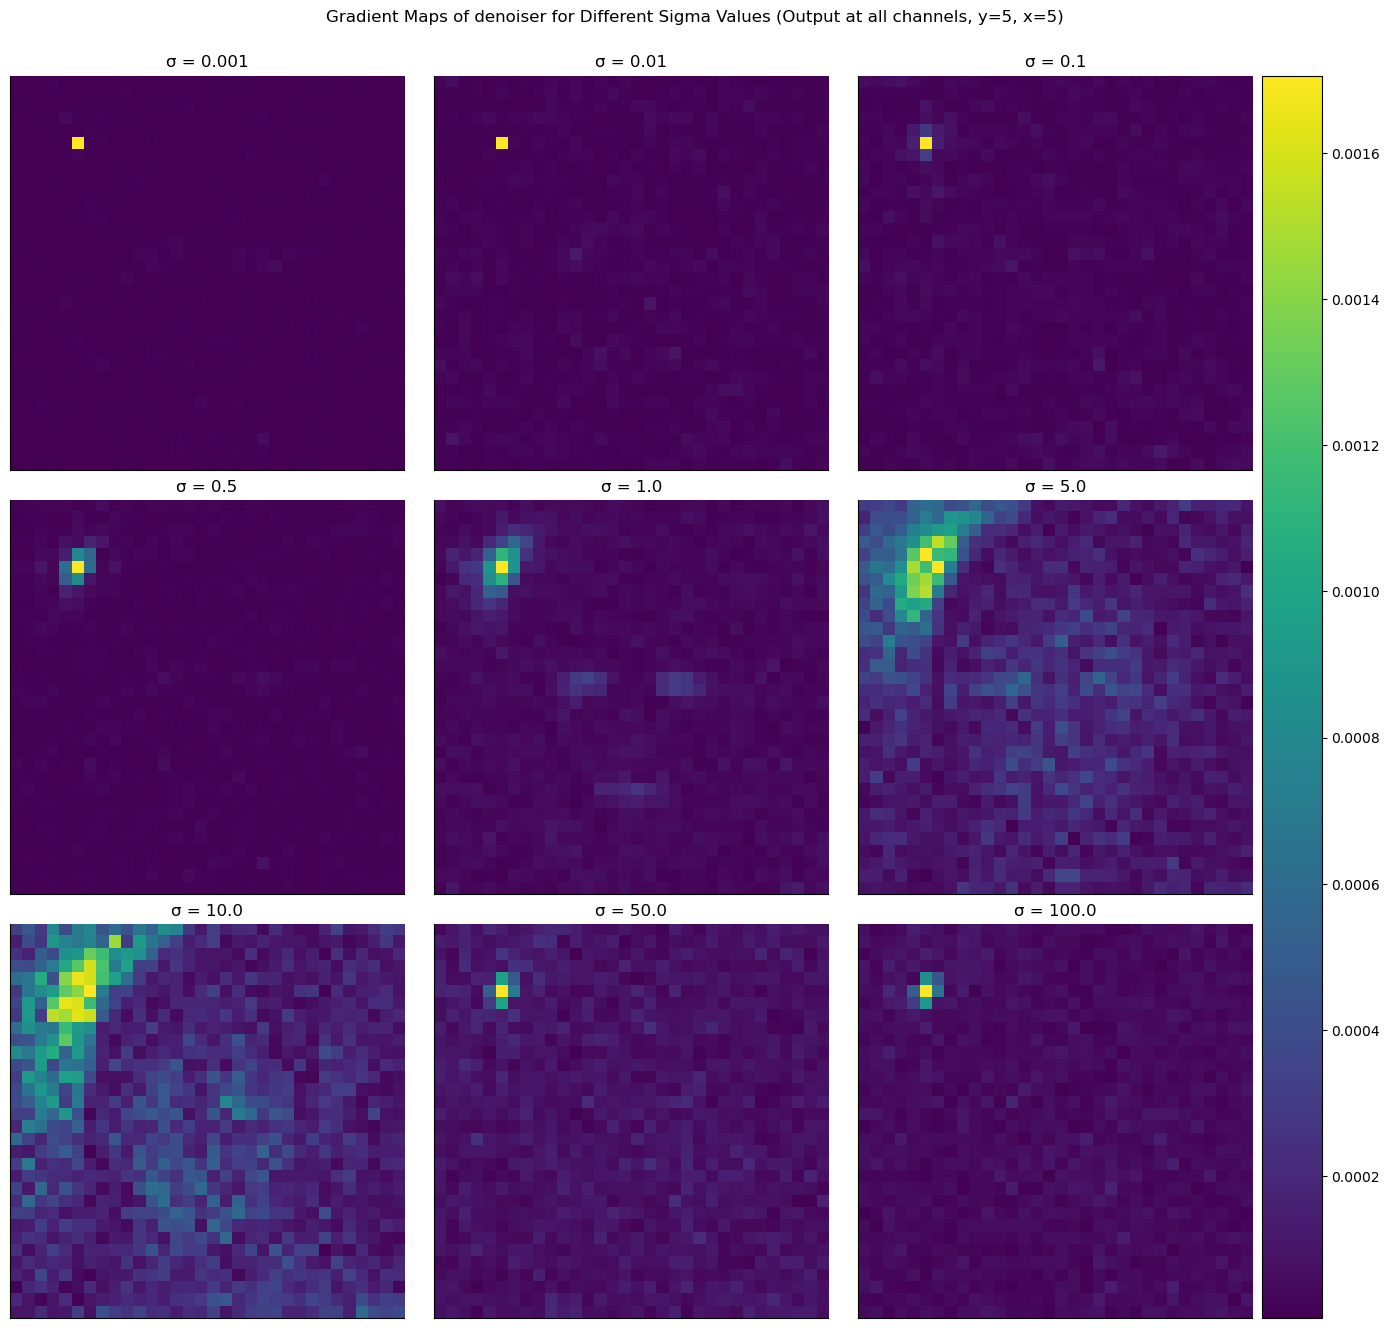

In [124]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, target="denoiser", output_coords=(None, 5, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


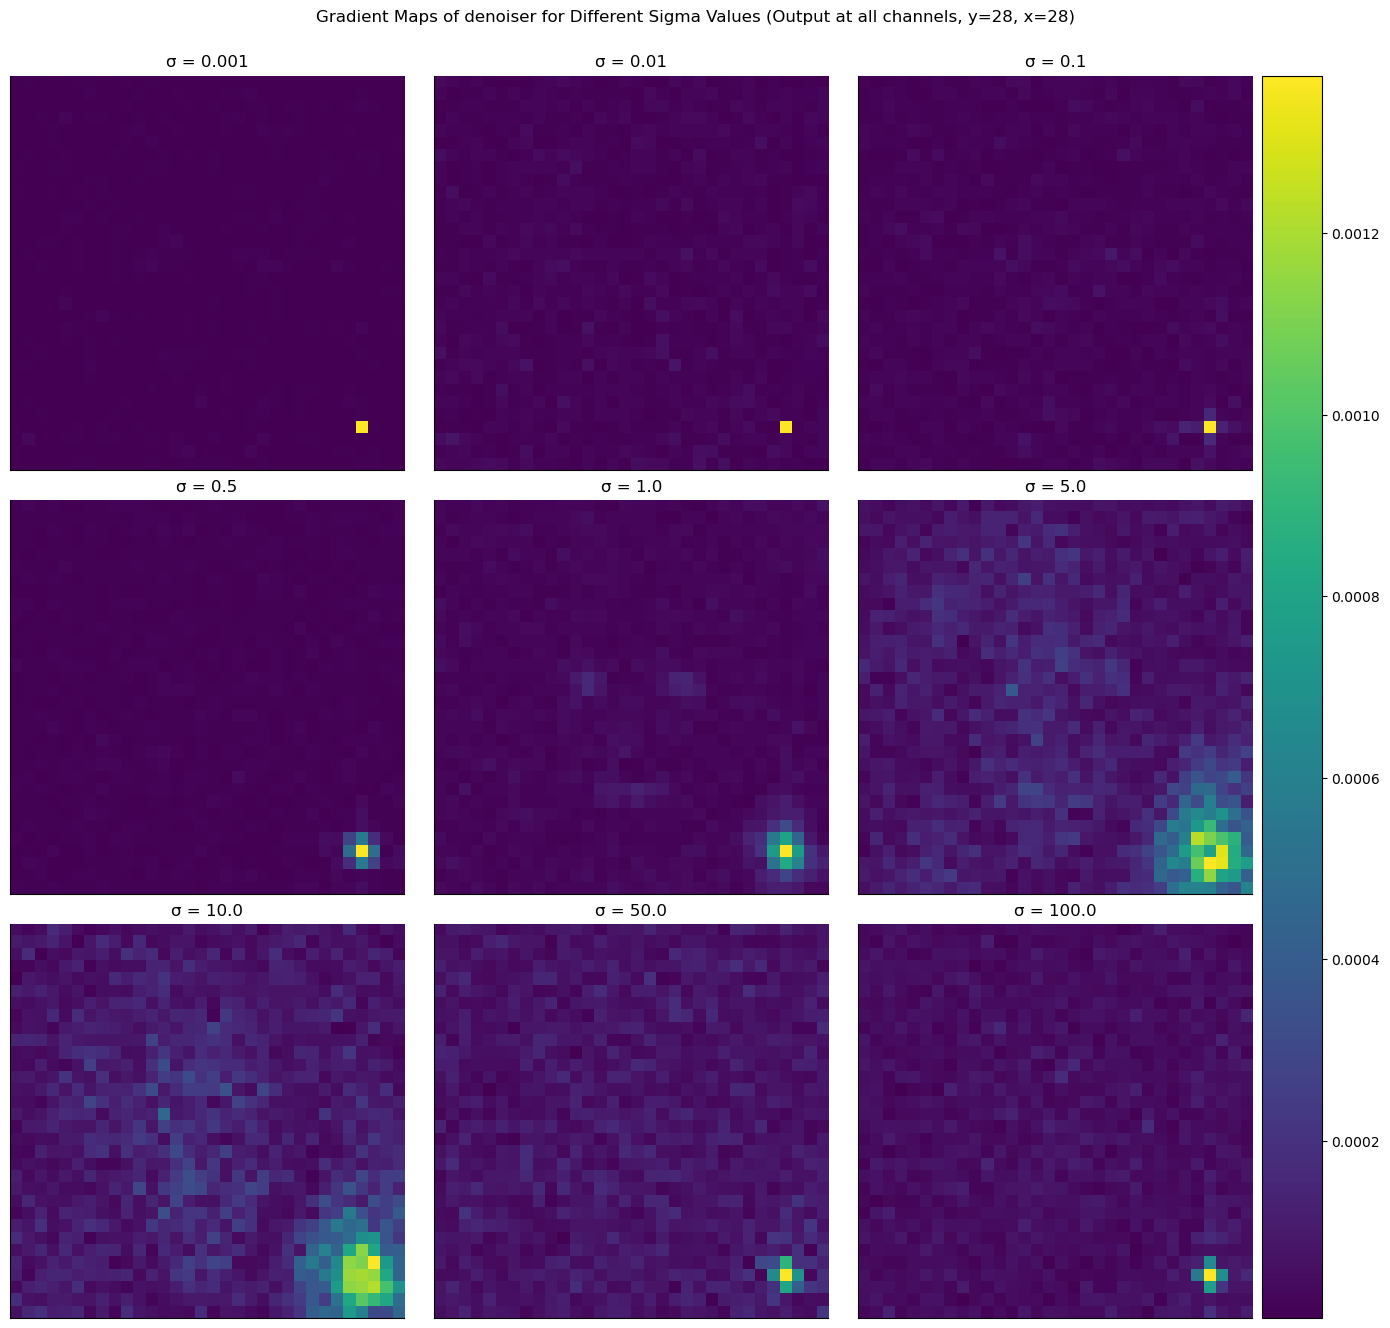

In [125]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, target="denoiser", output_coords=(None, 28, 28));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


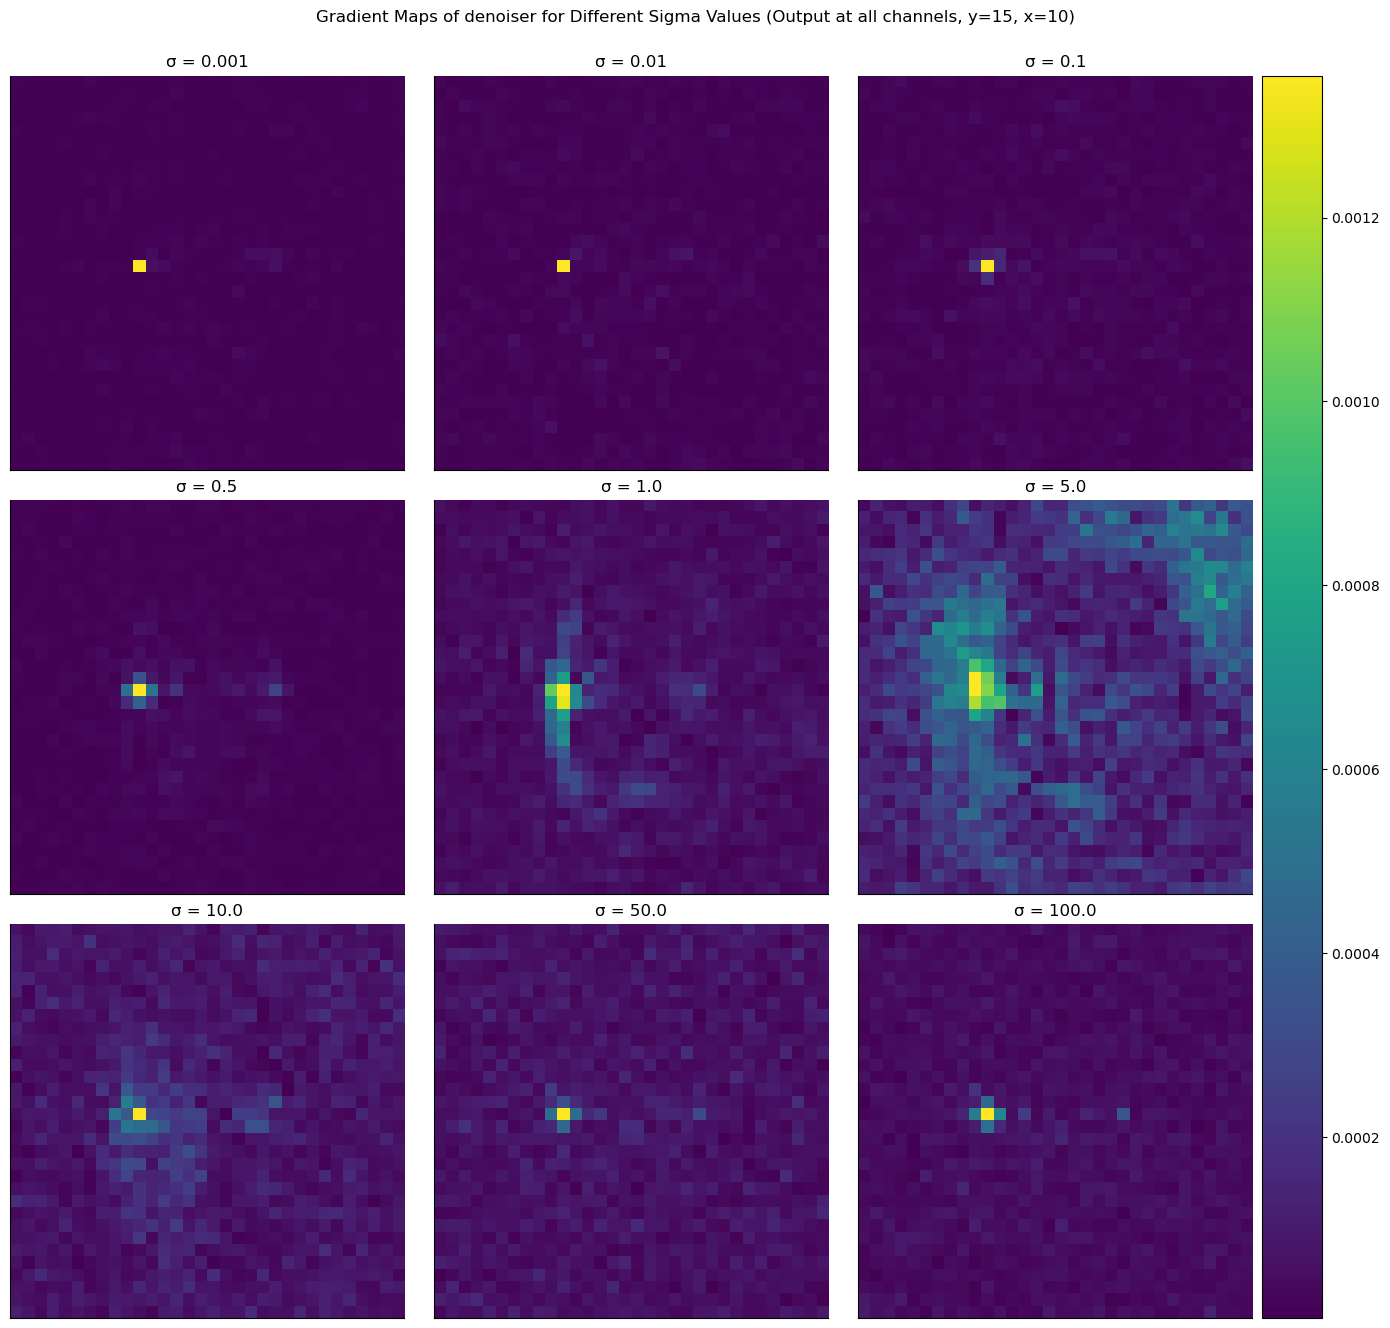

In [126]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, target="denoiser", output_coords=(None, 15, 10));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


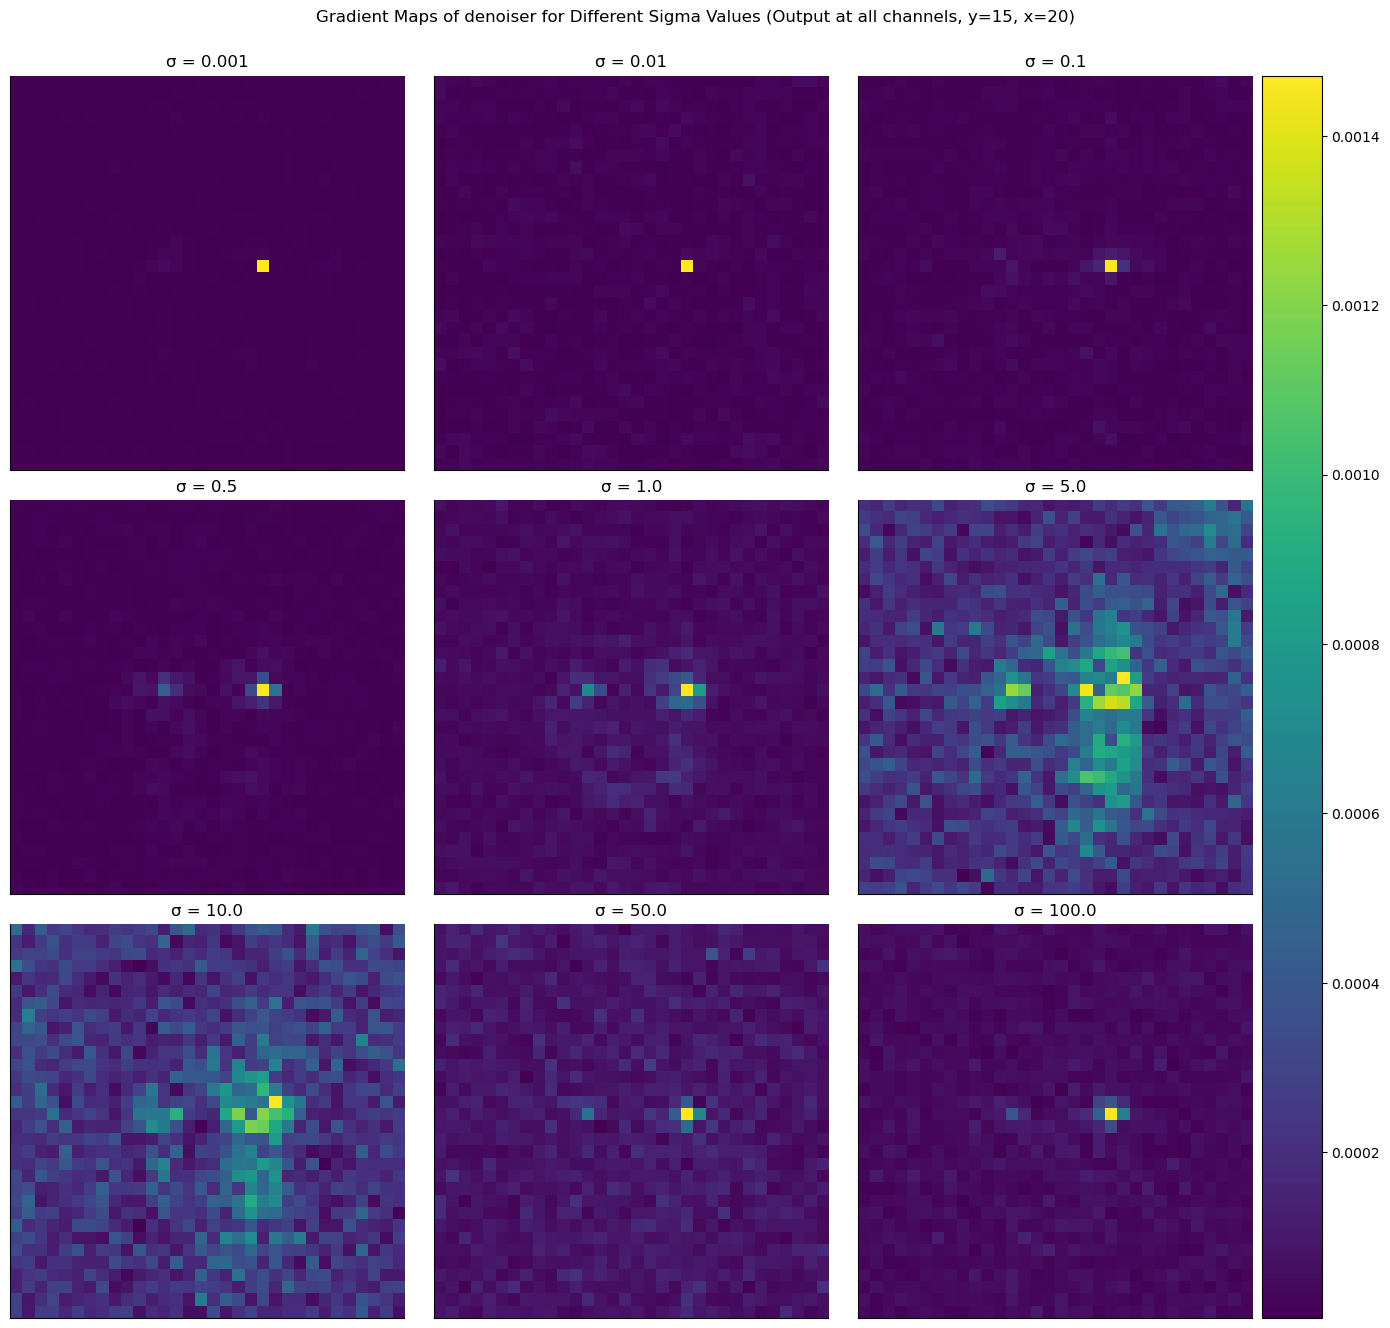

In [127]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(MLP_precd_img, imgshape, sigma_values, target="denoiser", output_coords=(None, 15, 20));

### Loading DiT

In [128]:
# loading config 
expname = "FFHQ32_DiT_P2_192D_3H_6L_EDM_saveckpt_fewsample"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
DiT_model = DiT(**config)
DiT_precd = EDMDiTPrecondWrapper(DiT_model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

{'class_dropout_prob': 0.1,
 'depth': 6,
 'hidden_size': 192,
 'in_channels': 3,
 'input_size': 32,
 'learn_sigma': False,
 'mlp_ratio': 4,
 'num_classes': 0,
 'num_heads': 3,
 'patch_size': 2}


In [ ]:
# ckpt_step = 1357
# Find the largest checkpoint step in the directory
ckpt_step = find_largest_ckpt_step(ckptdir)
ckpt_path = join(ckptdir, f"model_epoch_{ckpt_step:06d}.pth")
DiT_precd.load_state_dict(torch.load(ckpt_path))

Found 88 checkpoints in the directory, largest step is 49999


<All keys matched successfully>

In [130]:
device = "cuda"
DiT_precd = DiT_precd.to(device).eval()
DiT_precd.requires_grad_(False);

#### Gradient Map of DiT denoisers

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


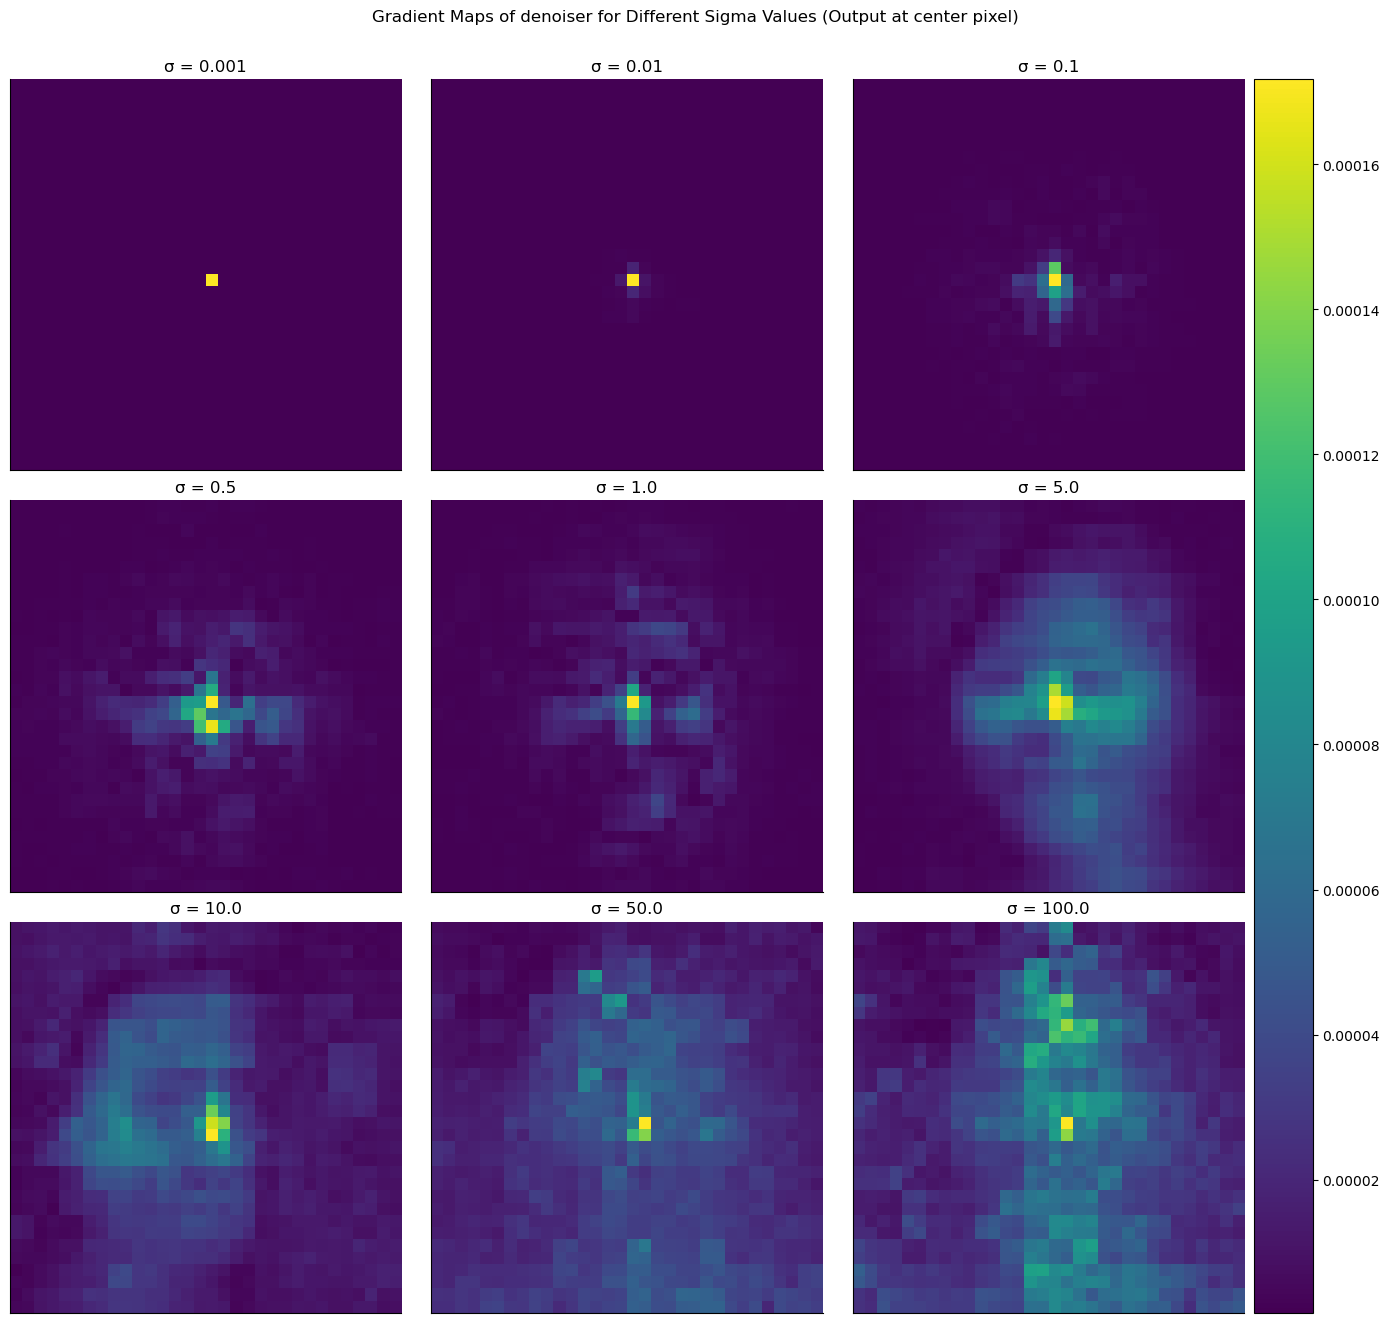

In [131]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser");#output_coords=(None, 28, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


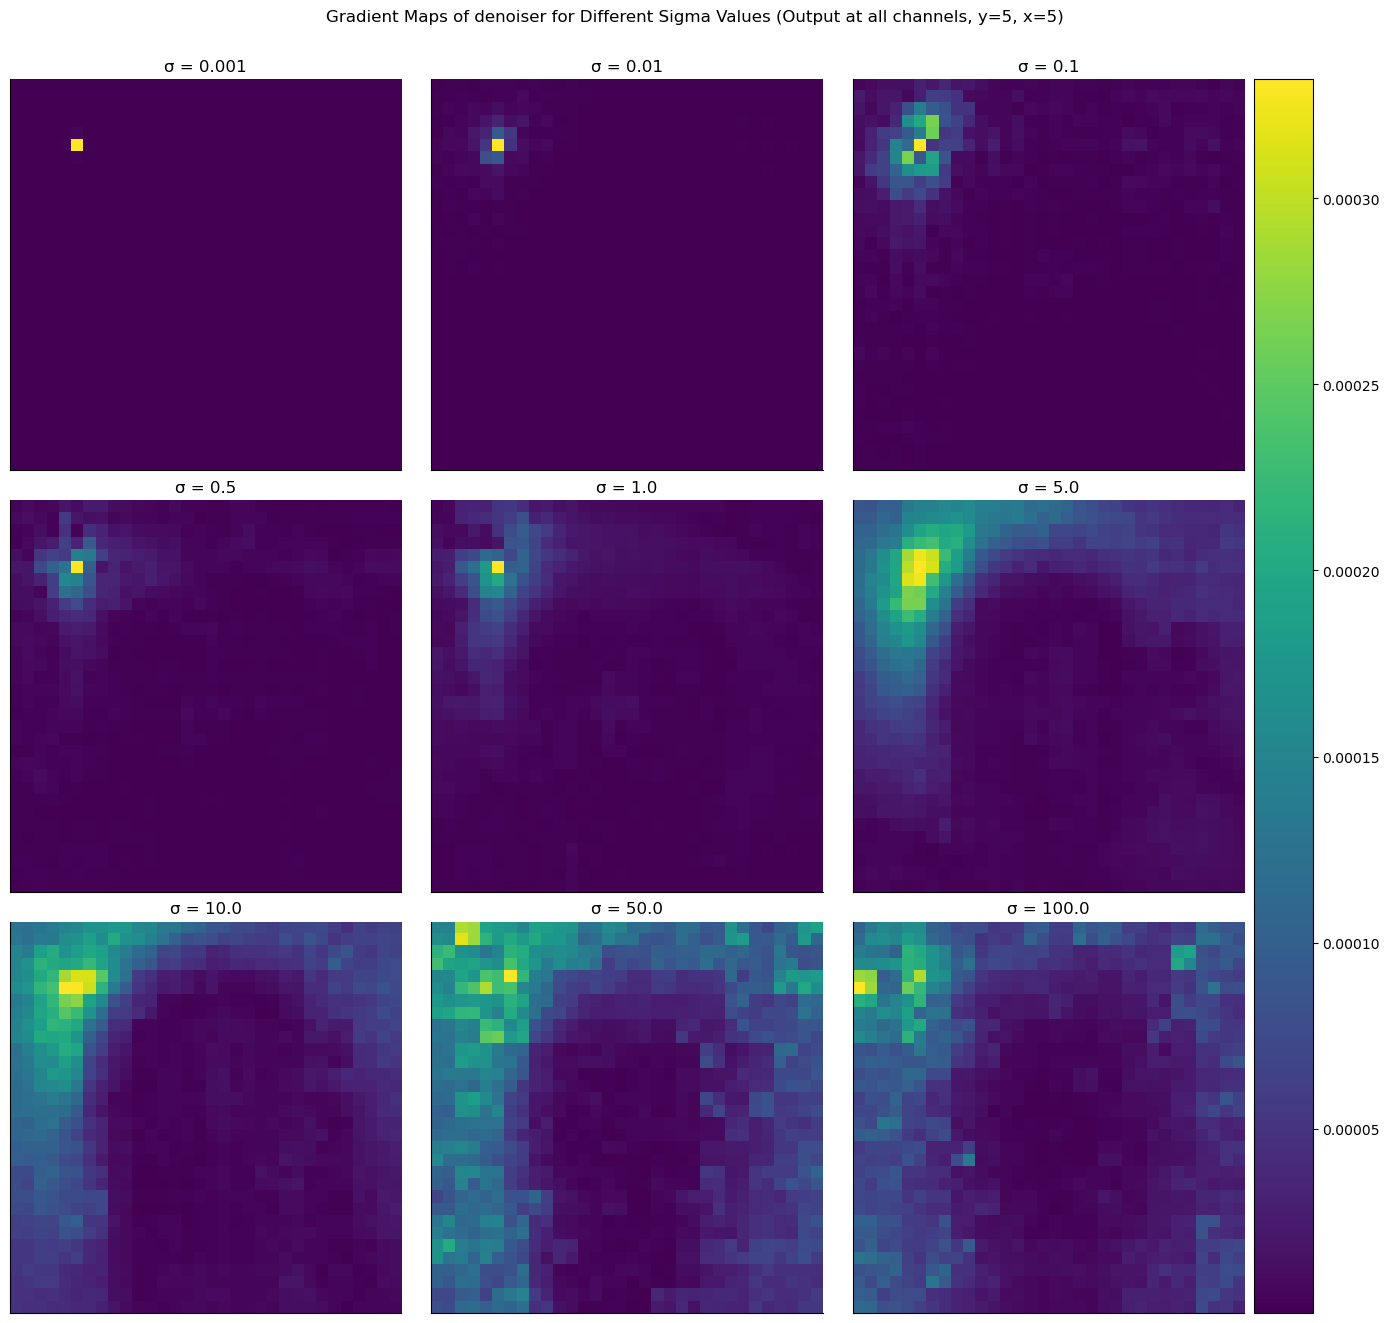

In [132]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser", output_coords=(None, 5, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


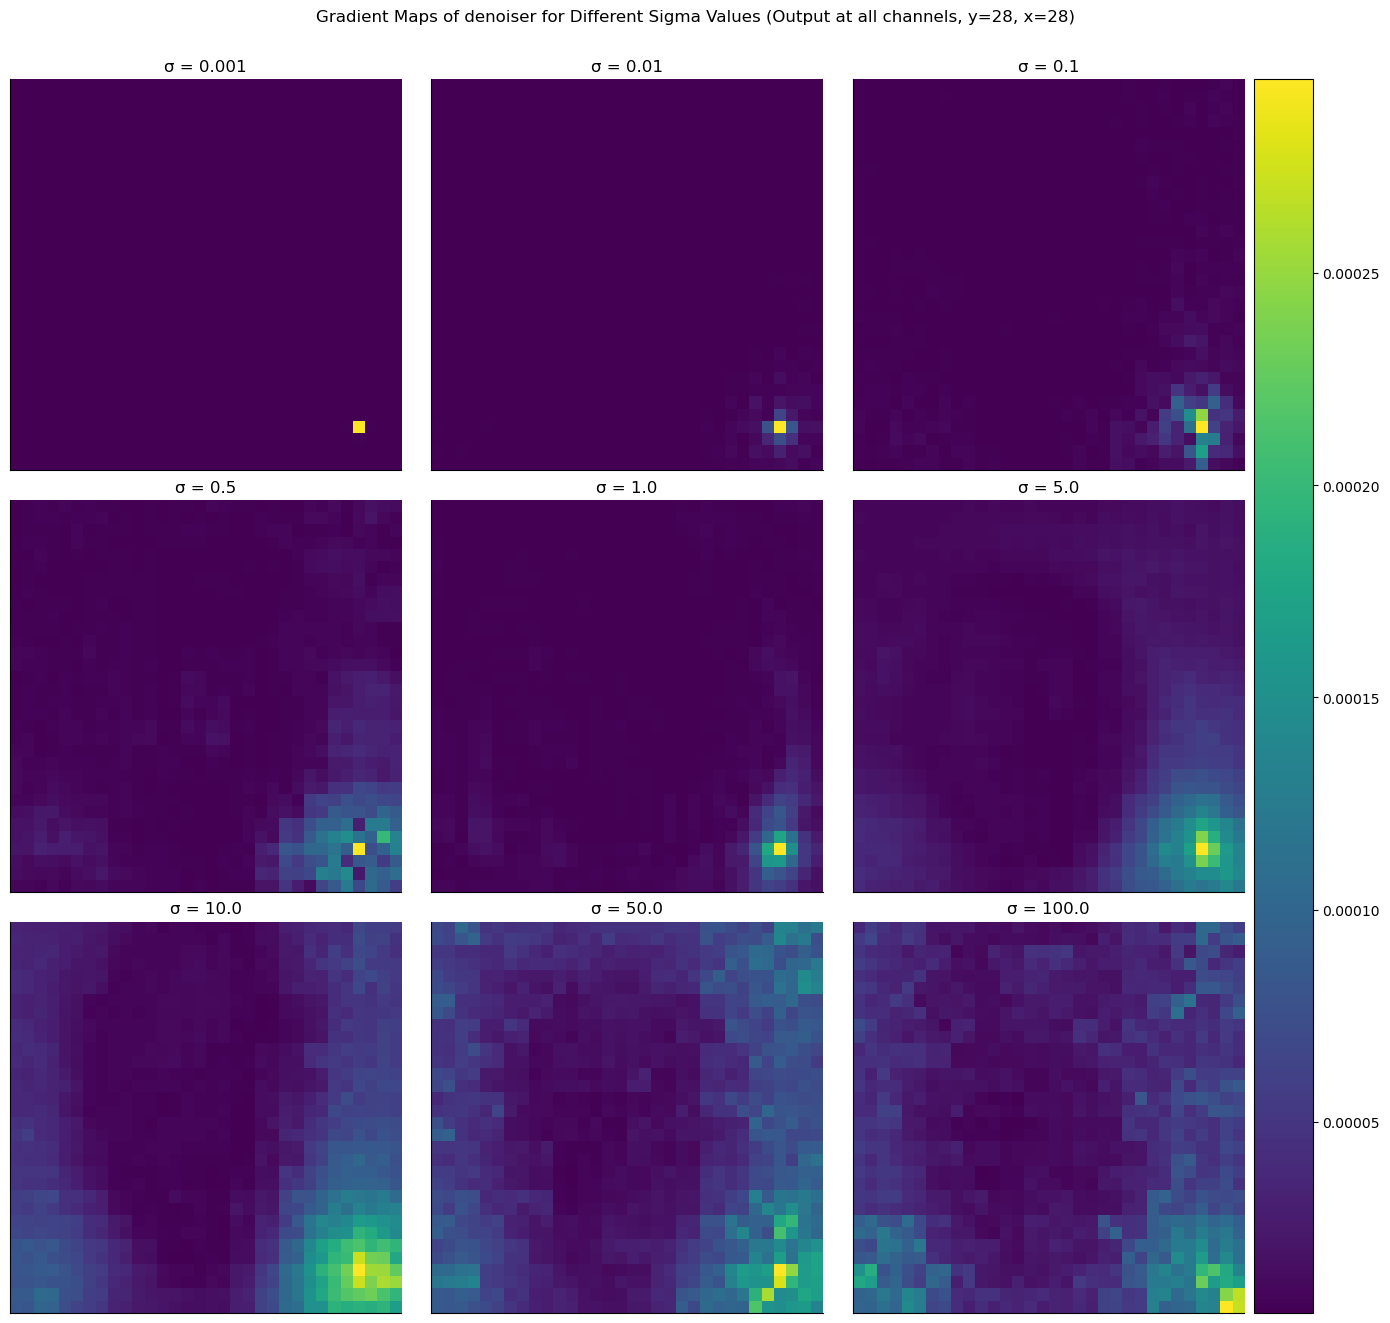

In [133]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser", output_coords=(None, 28, 28));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


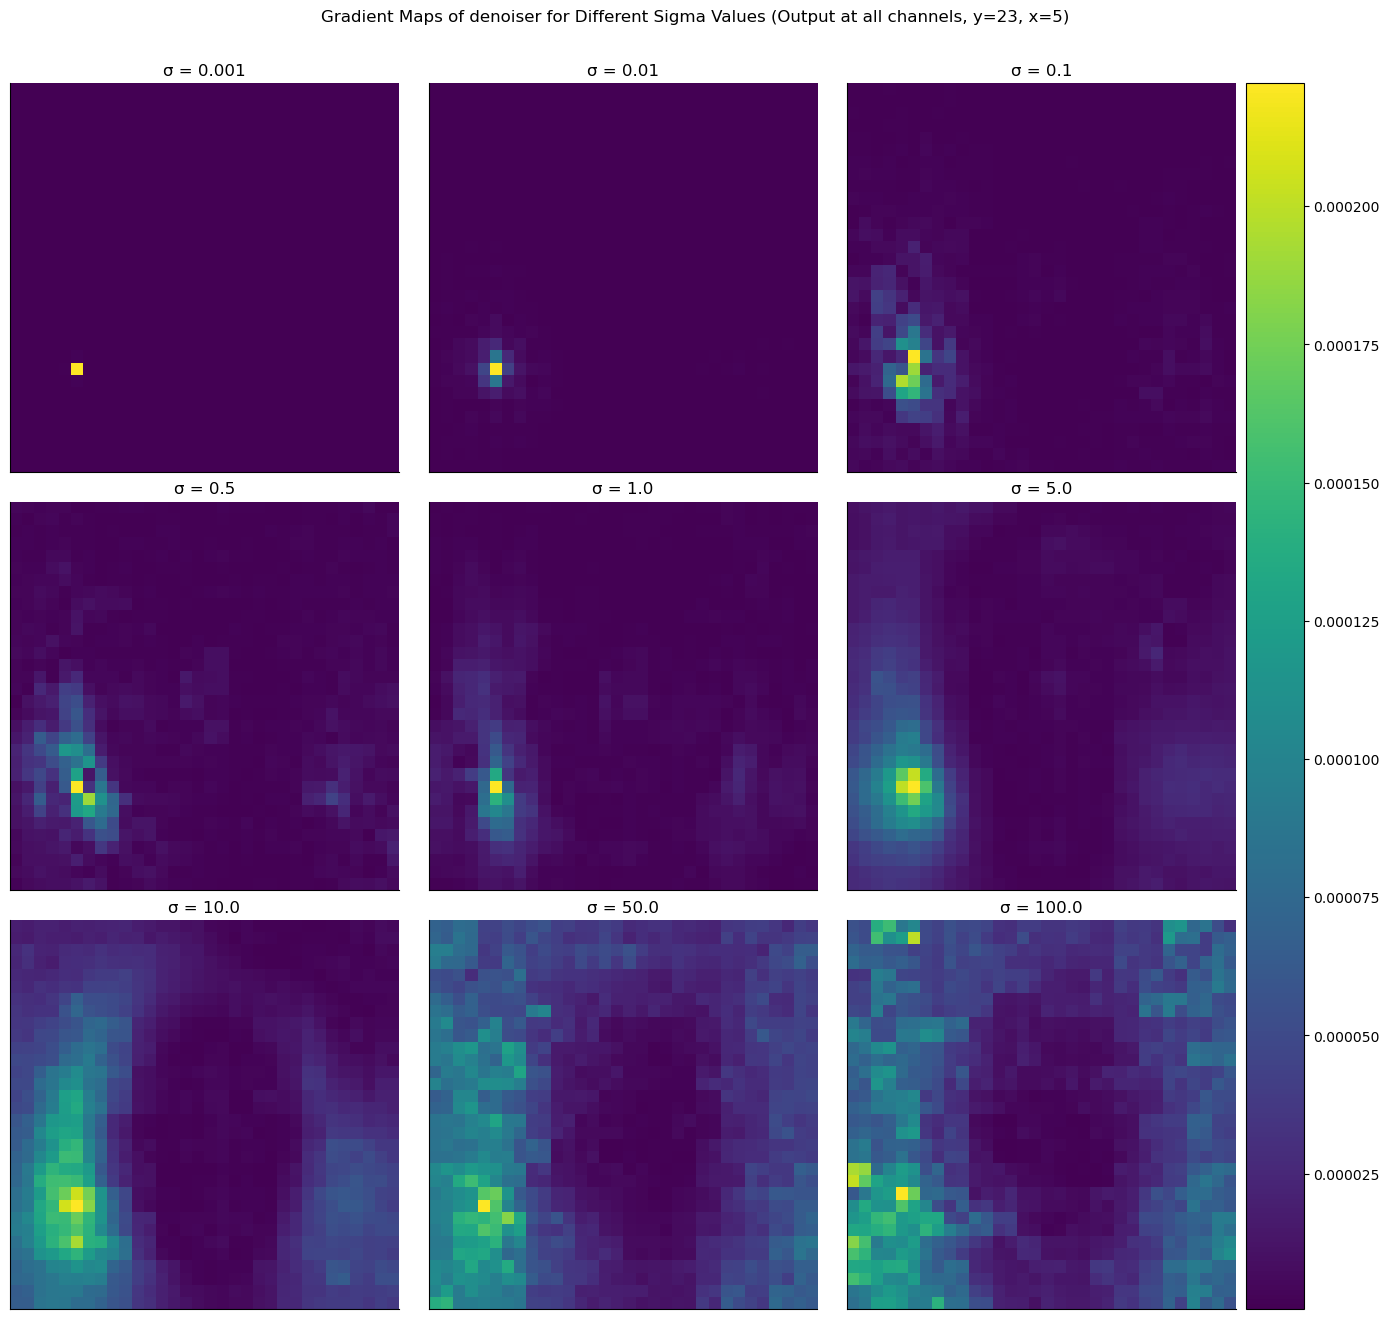

In [134]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser", output_coords=(None, 23, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


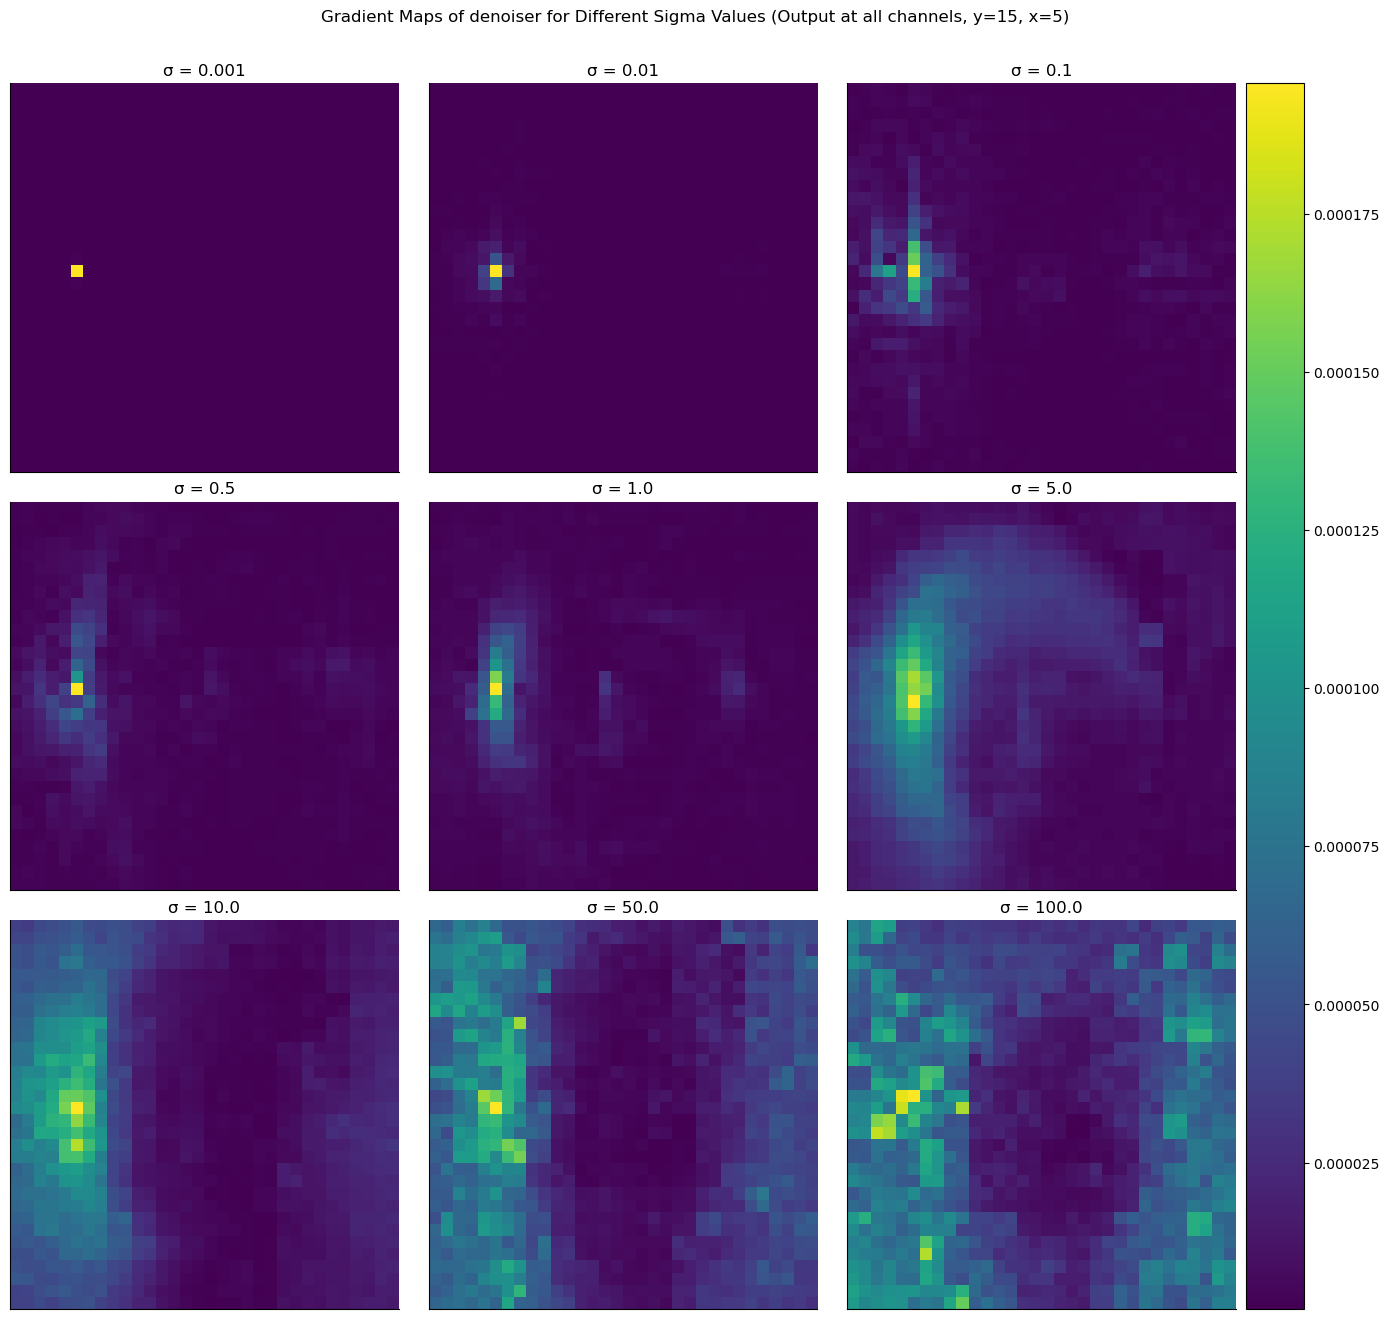

In [135]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser", output_coords=(None, 15, 5));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


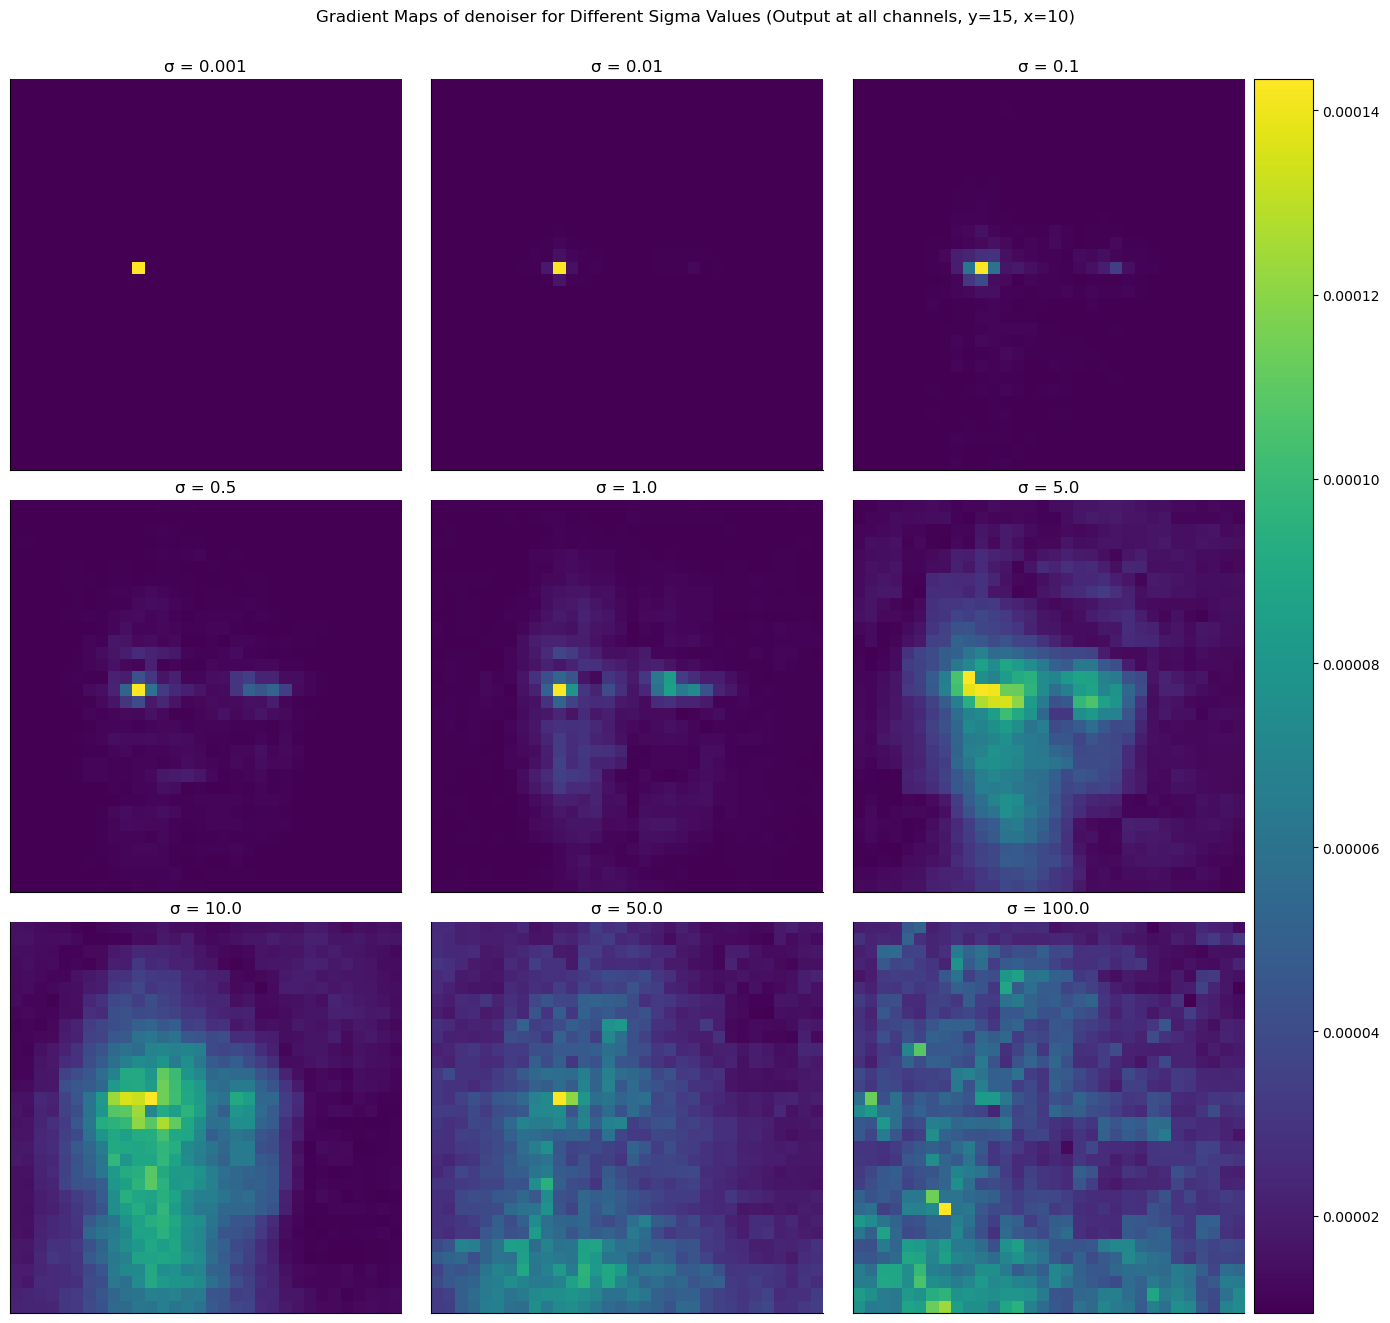

In [136]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser", output_coords=(None, 15, 10));

Computing gradient map for sigma = 0.001
Computing gradient map for sigma = 0.01
Computing gradient map for sigma = 0.1
Computing gradient map for sigma = 0.5
Computing gradient map for sigma = 1.0
Computing gradient map for sigma = 5.0
Computing gradient map for sigma = 10.0
Computing gradient map for sigma = 50.0
Computing gradient map for sigma = 100.0


/tmp/ipykernel_1050056/624291231.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


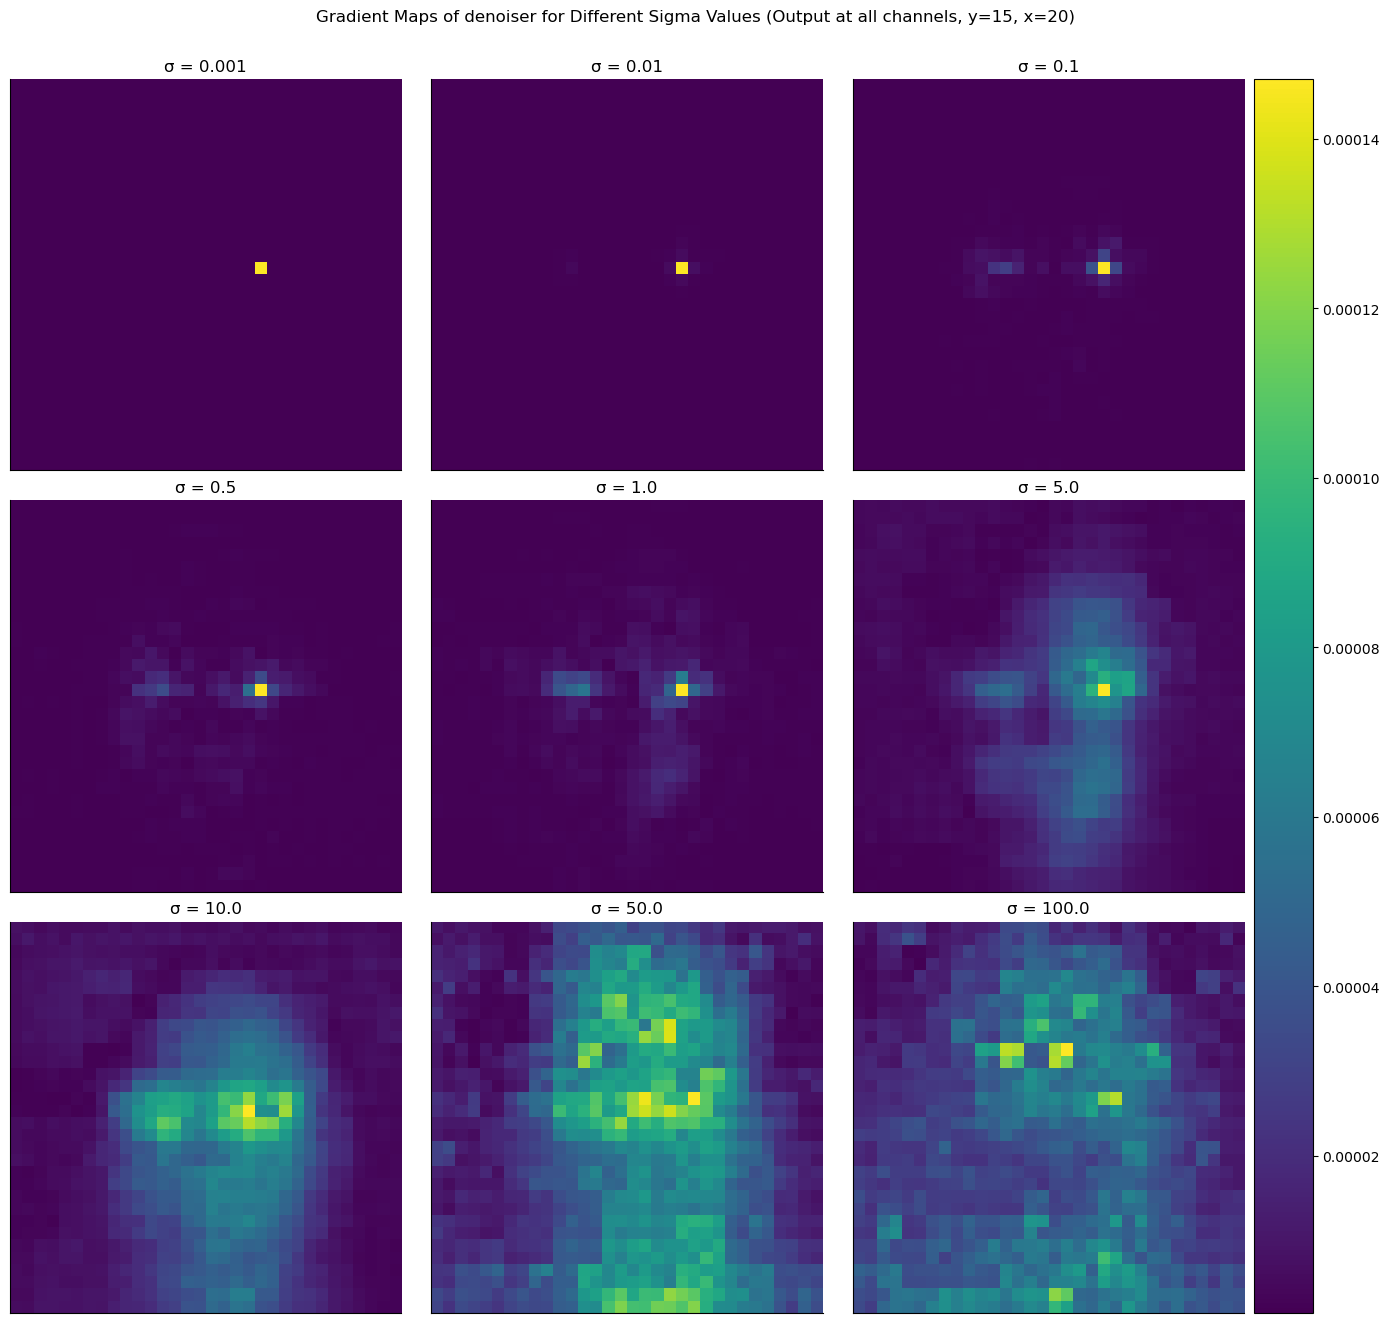

In [137]:
# Example usage:
sigma_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
grad_maps = visualize_gradient_maps(DiT_precd, imgshape, sigma_values, target="denoiser", output_coords=(None, 15, 20));